# Explainability of DL-based embeddings




### Importing packages

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import torch
import opensmile
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score, average='weighted')
from transformers import AutoFeatureExtractor, AutoModel

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Upload kaggle.json to download the EmoDB dataset
!mkdir .kaggle
!cp ../kaggle.json .kaggle/
!chmod 600 .kaggle/kaggle.json

mkdir: .kaggle: File exists


## Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [3]:
np.random.seed(42)

# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files

  Parameters
  ------------
  audio_files: string
      The paths of the wav files
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))

  return audio_list


### Loading and resampling audiofiles and collecting metadata on EmoDB dataset

In [4]:
from pathlib import Path
from collections import Counter

# Phase_1
# Load dataset
! kaggle datasets download -q -d uwrfkaggler/ravdess-emotional-speech-audio
! unzip -q ravdess-emotional-speech-audio.zip -d './ravdess'

# Select all the audio files
audios = []
for file in Path('./ravdess/audio_speech_actors_01-24').glob("**/*.wav"):
    if not file.is_file():
        continue
    audios.append(str(file))

# Load and resample audio files
audio_list = load_audio_files(audios, resampling_frequency=16000)

# Making speakers list and labels list
speakers = []
labels = []
for audio_file in audios:
  if 'audio_speech_actors_01-24' in audio_file:
    try:
      file_name = audio_file.split('/')[3]
      speakers.append(file_name[18:20])
      labels.append(file_name[6:8])
    except Exception as e:
      print(e)     
      print(audio_file)

label_dict = {'01': 'neutrality', '02': 'calm', '03': 'joy', '04': 'sadness', '05': 'anger', '06': 'fear', '07': 'disgust', '08': 'surprise'}
labels = [label_dict[emotion] for emotion in labels]

# Verify phase_1
print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))
frequency_dict = Counter(labels)
print('frequency dict:', frequency_dict)

Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
Number of audio files: 1440
Number of speaker classes: 24
Speaker classes: {'21', '05', '22', '01', '03', '24', '02', '10', '15', '16', '18', '07', '06', '20', '12', '11', '14', '08', '04', '19', '17', '13', '09', '23'}
Number of speakers: 1440
Number of label classes: 8
Label classes: {'sadness', 'anger', 'disgust', 'calm', 'neutrality', 'joy', 'surprise', 'fear'}
Number of labels: 1440
frequency dict: Counter({'anger': 192, 'fear': 192, 'disgust': 192, 'sadness': 192, 'surprise': 192, 'joy': 192, 'calm': 192, 'neutrality': 96})


## Embedding Extraction
Includes extracting features using
- Deep learning based methods: WavLM
- DSP based methods: openSMILE eGeMAPS

### Audio embeddings extraction functions

In [8]:
# Defining a function for generating audio embedding extraction models

def audio_embeddings_model(model_name):
    '''
    Generates model for embedding extraction

    Parameters
    ------------
    mode_name: string
        The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

    Returns
    ------------
    model: object
        The embedding extraction model
    '''
    if model_name=='compare':
        model = opensmile.Smile(
            feature_set=opensmile.FeatureSet.ComParE_2016,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    elif model_name=='egemaps':
        model = opensmile.Smile(
            feature_set=opensmile.FeatureSet.eGeMAPSv02,
            feature_level=opensmile.FeatureLevel.Functionals,
        )
    return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
    '''
    Loads and resamples audio files

    Parameters
    ------------
    audio_list: list
        A list of arrays, one array for each audio file
    model_name: string
        The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
    model: object
        The embedding extraction model generated by audio_embeddings_model function
    sampling_rate: int
        The sampling rate, 16 kHz by default

    Returns
    ------------
    embeddings_array: array
        The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)

    '''

    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
        embeddings = model.process_signal(audio_list[i], sampling_rate)
        embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
    return embeddings_array


def audio_embeddings_wavlm(audio_list, sampling_rate=16000):
  """
  Extracts embeddings from audio list using WavLM.

  Args:
      audio_list: List of audio file paths or audio data arrays.
      sampling_rate: Sampling rate of the audio (default: 16000).

  Returns:
      torch.Tensor: Embeddings for each audio file in the list.
  """
  embeddings_list = []
  for audio in tqdm(audio_list):

      inputs = feature_extractor(audio, sampling_rate=sampling_rate, return_tensors="pt")

      with torch.no_grad():
          outputs = model(**inputs)
          embeddings = outputs.last_hidden_state
          embeddings = torch.mean(embeddings, dim=1)
      embeddings_list.append(embeddings)

  return torch.cat(embeddings_list, dim=0)


def get_egemaps_feature_names():
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    egemaps_feature_names = model.column_names

    return egemaps_feature_names



In [9]:
egemaps_feature_names = get_egemaps_feature_names()
def remove_substring(strings, target):
    return [s.replace(target, '') for s in strings]

# egemaps_feature_names = remove_substring(egemaps_feature_names, '_sma3nz')
# egemaps_feature_names = remove_substring(egemaps_feature_names, '_sma3')
print(egemaps_feature_names)

Index(['F0semitoneFrom27.5Hz_sma3nz_amean',
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean',
       'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0',
       'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0',
       'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope',
       'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean',
       'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean',
       'mfcc1_sma3_stddevNorm', 'mfcc2_

### Audio embeddings extraction on EmoDB

In [10]:
# WavLM
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-large")
model = AutoModel.from_pretrained("microsoft/wavlm-large")
embeddings_array_WavLM = audio_embeddings_wavlm(audio_list)
# embeddings_array_WavLM = np.load("wavlm_embeddings_ravdess.npy")
print(embeddings_array_WavLM.shape)

# EmoDB egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)

# ---------------------------------------------------------------------------------------------------

# Verify Phase_2
models = ['WavLM', 'egemaps']
embeddings_arrays = {'WavLM': embeddings_array_WavLM, 'egemaps':embeddings_array_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))


100%|██████████| 1440/1440 [14:40<00:00,  1.63it/s]


torch.Size([1440, 1024])


100%|██████████| 1440/1440 [01:08<00:00, 20.91it/s]



MODEL: WavLM

The shape of the embeddings array is torch.Size([1440, 1024])


MODEL: egemaps

The shape of the embeddings array is torch.Size([1440, 88])


In [11]:

# Defining a function for speaker normalisation using standard scaler

def speaker_normalisation(embeddings_array, speakers):
    '''
    Normalises embeddings_array for each speaker

    Parameters
    ------------
    embeddings_array: array
        The array of embeddings, one row for each audio file
    speakers: list
        The list of speakers

    Returns
    ------------
    embeddings_array: array
        The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)

    '''
    speaker_ids = set(speakers)
    for speaker_id in speaker_ids:
        speaker_embeddings_indices = np.where(np.array(speakers)==speaker_id)[0]
        speaker_embeddings = embeddings_array[speaker_embeddings_indices,:]
        scaler = StandardScaler()
        normalised_speaker_embeddings = scaler.fit_transform(speaker_embeddings)
        embeddings_array[speaker_embeddings_indices] = torch.tensor(normalised_speaker_embeddings).float()
    return embeddings_array

embeddings_arrays['WavLM'] = speaker_normalisation(embeddings_arrays['WavLM'], speakers)
embeddings_arrays['egemaps'] = speaker_normalisation(embeddings_arrays['egemaps'], speakers)


# Classification + SHAP Code
Code for the classification task and getting the SHAP feature importance for every eGeMAPS feature and every WaVLM embedding dimension for each emotion


In [12]:
# function for dividing the dataset into dictionaries with emotions as keys and embeddings/labels/speakers as values

def label_division(embeddings_array, labels, required_labels, speakers):
    np.random.seed(42)
    final_embeddings_dict = {}
    final_labels_dict = {}
    final_speakers_list_dict = {}

    for label in required_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        label_embeddings = embeddings_array[label_indices, :]
        final_speakers_list_dict[label] = list(np.array(speakers)[label_indices])
        final_embeddings_dict[label] = label_embeddings
        final_labels_dict[label] = [label] * len(label_indices)

    return final_embeddings_dict, final_labels_dict, final_speakers_list_dict


In [13]:
# function for combining one emotion (50%) and the rest of the 5 emotions (10% each)

def emotion_all_merger(emotion, other_emotions, wavlm_embeddings_dict, egemaps_embeddings_dict, speakers_dict, num=96):

  np.random.seed(42)
  print(len(speakers_dict[emotion]), num)
  emo_indices = np.random.choice(len(speakers_dict[emotion]), size=num, replace=False)

  wavlm_embeddings = wavlm_embeddings_dict[emotion][emo_indices]
  egemaps_embeddings = egemaps_embeddings_dict[emotion][emo_indices]
  speakers = [speakers_dict[emotion][i] for i in emo_indices]
  labels = [1]*num

  for em in other_emotions:
    em_indices = np.random.choice(len(speakers_dict[em]), size=int(num/len(other_emotions)), replace=False)
    em_speakers = [speakers_dict[em][i] for i in em_indices]
    wavlm_embeddings_emo = wavlm_embeddings_dict[em][em_indices]
    egemaps_embeddings_emo = egemaps_embeddings_dict[em][em_indices]
    # print('egemaps_embeddings_emo.shape', egemaps_embeddings_emo.shape)
    # print('wavlm_embeddings_emo.shape', wavlm_embeddings_emo.shape)

    wavlm_embeddings = np.concatenate((wavlm_embeddings, wavlm_embeddings_emo), axis=0)
    egemaps_embeddings = np.concatenate((egemaps_embeddings, egemaps_embeddings_emo), axis=0)
    # print('w_embeddings.shape', w_embeddings.shape)
    # print('e_embeddings.shape', e_embeddings.shape)

    speakers = speakers + em_speakers
    labels = labels + [0]*int(num/len(other_emotions))

  return wavlm_embeddings, egemaps_embeddings, labels, speakers


In [14]:
wavlm_embeddings_dict, wavlm_labels_dict, wavlm_speakers_list_dict = label_division(embeddings_array=embeddings_array_WavLM, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)
eGeMAPS_embeddings_dict, eGeMAPS_labels_dict, eGeMAPS_speakers_list_dict = label_division(embeddings_array=embeddings_array_egemaps, labels=labels, required_labels=['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust'], speakers=speakers)

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

wavlm_embeddings_all = {}
egemaps_embeddings_all = {}
speakers_all = {}
labels_all = {}

for e in emotions:
    wavlm_embeddings, egemaps_embeddings, labels, speakers = emotion_all_merger(emotion=e, other_emotions=['neutrality'], wavlm_embeddings_dict=wavlm_embeddings_dict, egemaps_embeddings_dict=eGeMAPS_embeddings_dict, speakers_dict=eGeMAPS_speakers_list_dict, num=96)
    wavlm_embeddings_all[e] = wavlm_embeddings
    egemaps_embeddings_all[e] = egemaps_embeddings
    speakers_all[e] = speakers
    labels_all[e] = labels
    print(e)
    print('-'*20)
    print('speakers:', speakers)
    print('labels_all:', labels_all)
    print()


192 96
anger
--------------------
speakers: [np.str_('19'), np.str_('14'), np.str_('03'), np.str_('14'), np.str_('23'), np.str_('01'), np.str_('11'), np.str_('18'), np.str_('18'), np.str_('11'), np.str_('03'), np.str_('23'), np.str_('04'), np.str_('04'), np.str_('09'), np.str_('20'), np.str_('13'), np.str_('04'), np.str_('15'), np.str_('04'), np.str_('06'), np.str_('09'), np.str_('23'), np.str_('12'), np.str_('04'), np.str_('23'), np.str_('20'), np.str_('09'), np.str_('17'), np.str_('14'), np.str_('23'), np.str_('07'), np.str_('18'), np.str_('05'), np.str_('06'), np.str_('16'), np.str_('22'), np.str_('14'), np.str_('07'), np.str_('02'), np.str_('15'), np.str_('07'), np.str_('21'), np.str_('22'), np.str_('19'), np.str_('01'), np.str_('12'), np.str_('10'), np.str_('03'), np.str_('24'), np.str_('20'), np.str_('09'), np.str_('17'), np.str_('10'), np.str_('07'), np.str_('21'), np.str_('20'), np.str_('09'), np.str_('11'), np.str_('19'), np.str_('09'), np.str_('08'), np.str_('08'), np.str_('1

In [15]:
!pip install -q shap

In [16]:
import shap
import numpy as np

def feature_importance_method(X, y, feature_names, trained_model):
    # Create a SHAP explainer
    explainer = shap.Explainer(trained_model, X)

    # Calculate SHAP values
    shap_values = explainer(X)

    # Get the mean absolute SHAP values for each feature
    shap_mean_abs = np.mean(np.abs(shap_values.values), axis=0)

    # Get the indices of the sorted feature importances
    feature_indices = np.argsort(shap_mean_abs)[::-1]

    # Create a list of sorted feature importances
    sorted_importances = [(feature_names[i], shap_mean_abs[i]) for i in feature_indices]

    # Plot SHAP feature importance
    shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type='bar')

    return sorted_importances


In [17]:
# Function for nested cross validation

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']
Performance ={'eGeMAPS':{e:[] for e in emotions}, 'WavLM_all':{e:[] for e in emotions}, 'WavLM_top_features':{e:[] for e in emotions}}

def classification_pipeline(embeddings, speakers, labels_list, feature_names):

    np.random.seed(42)

    X = embeddings
    y = labels_list
    groups = speakers

    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

    # Outer cross-validation loop
    outer_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
    outer_scores = []
    feats_array = []
    for train_index, test_index in outer_cv.split(X, y, groups):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

        # Inner cross-validation loop for hyperparameter tuning
        inner_cv = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
        grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=inner_cv)
        grid_search.fit(X_train, y_train, groups=[groups[i] for i in train_index])

        # Get the best hyperparameters found in the inner loop
        best_params = grid_search.best_params_

        # Fit the model with the best hyperparameters on the training data
        model = LogisticRegression( **best_params)

        # Standardize X_train and transform X_test
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)

        # Evaluate the model on the test data
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='binary')
        outer_scores.append(score)

    # Compute and print the mean F1 score across all outer folds
    mean_f1 = np.round(100*np.mean(outer_scores), 1)
    print('F1:', mean_f1)
    return model, mean_f1



In [18]:
def find_x_at_n_percentile(x_values, y_values, n):
    percentile = np.percentile(y_values, n)
    for i, y in enumerate(y_values):
        if y >= percentile:
            x_at_nth_percentile = x_values[i]
            break

    return x_at_nth_percentile

# Classification + SHAP for eGeMAPS Features
Results for emotion classification (binary classification task) using eGeMAPS features. Also includes results for calculating SHAP score per feature for each emotion and identifying most important types of acoustic features (such as energy-based, spectral etc.) for every emotion

F1: 92.1


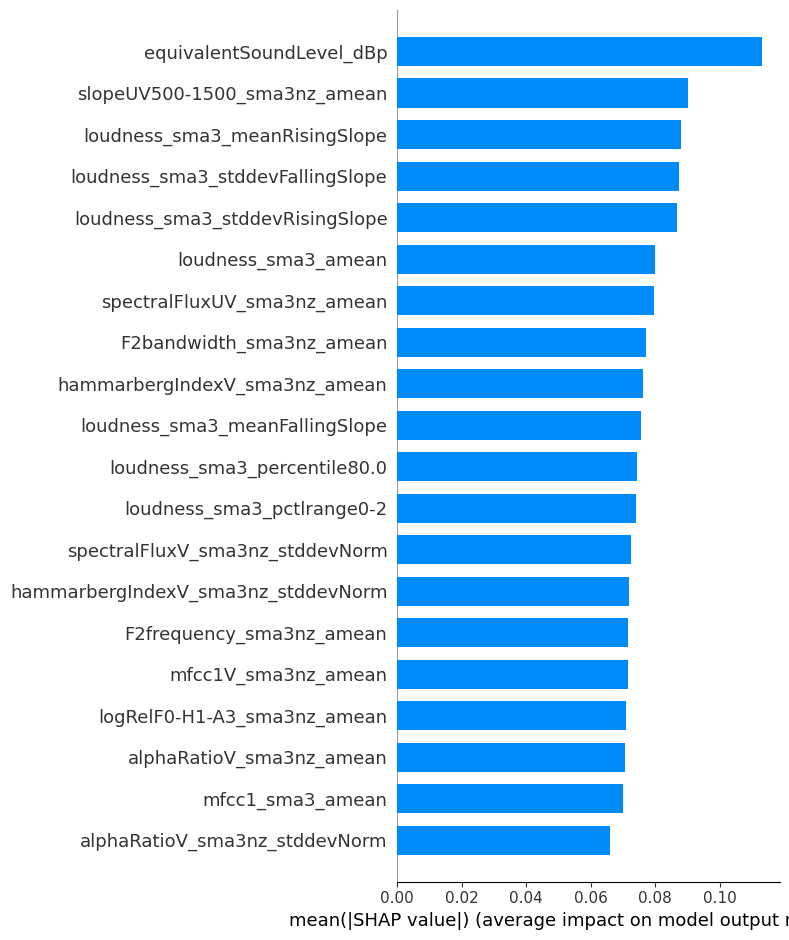

F1: 91.8


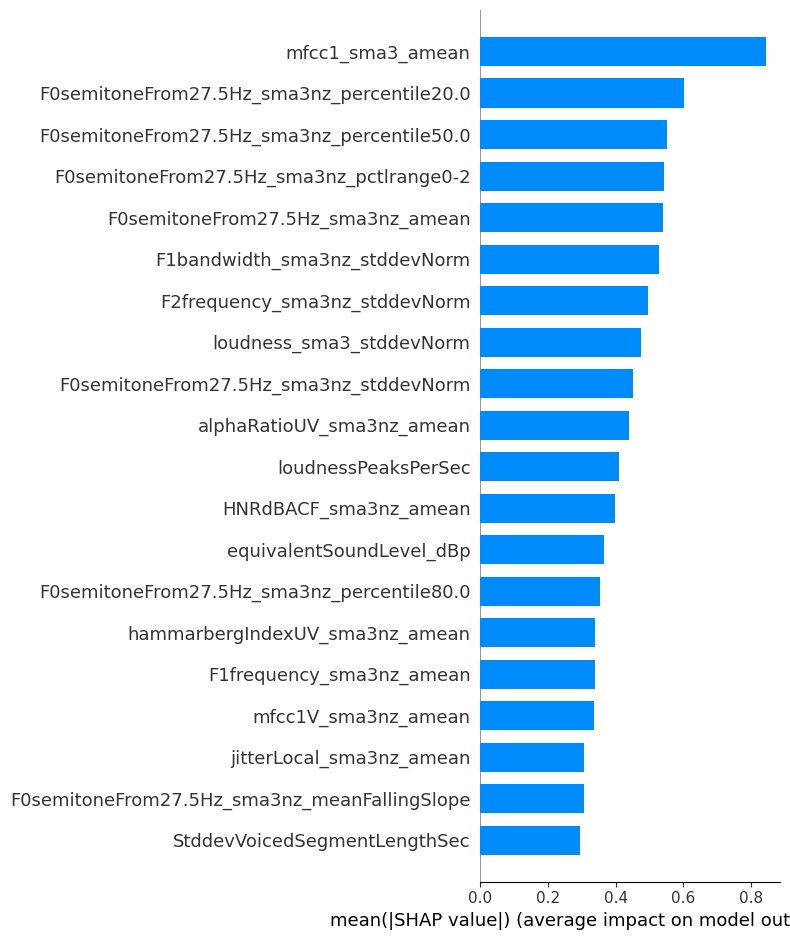

F1: 0.0


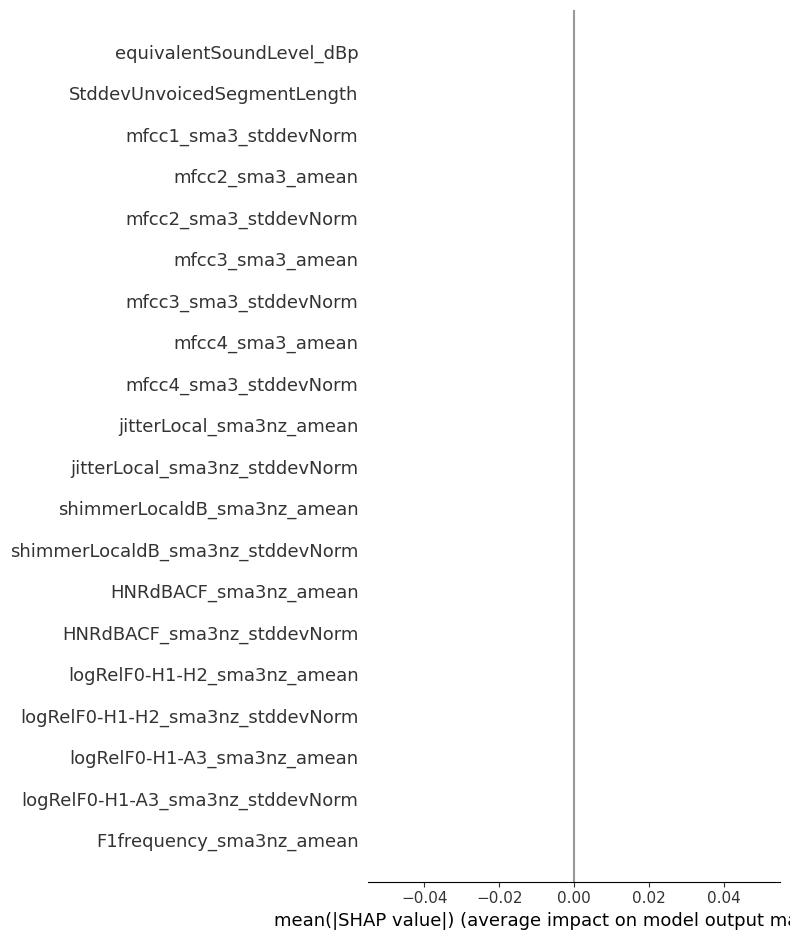

F1: 83.8


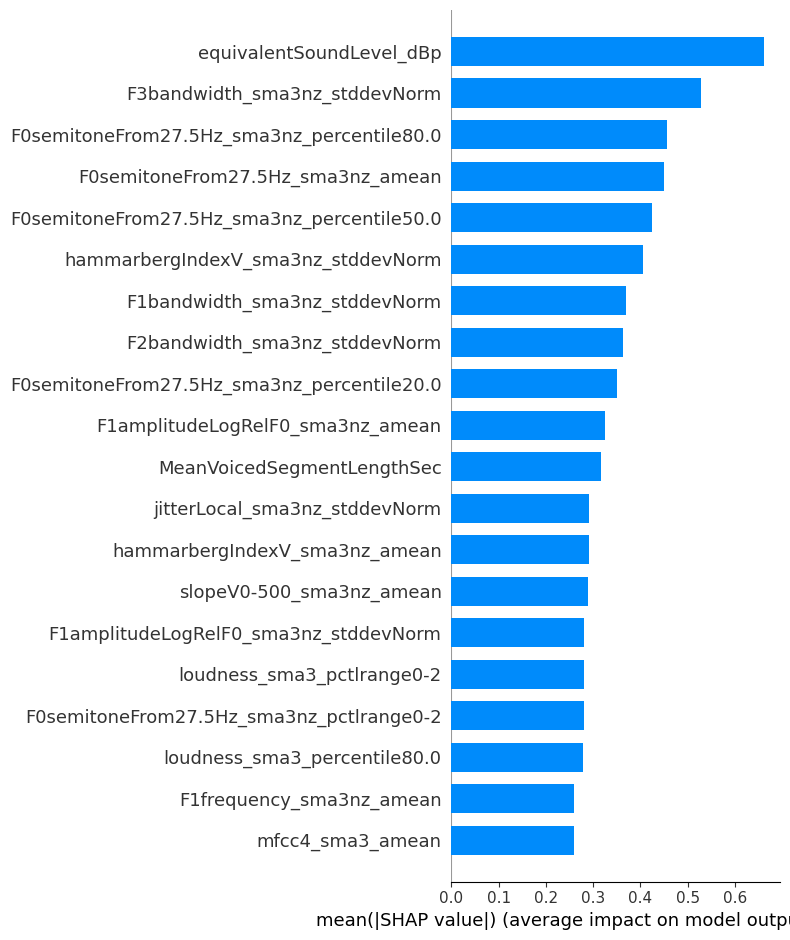

F1: 75.6


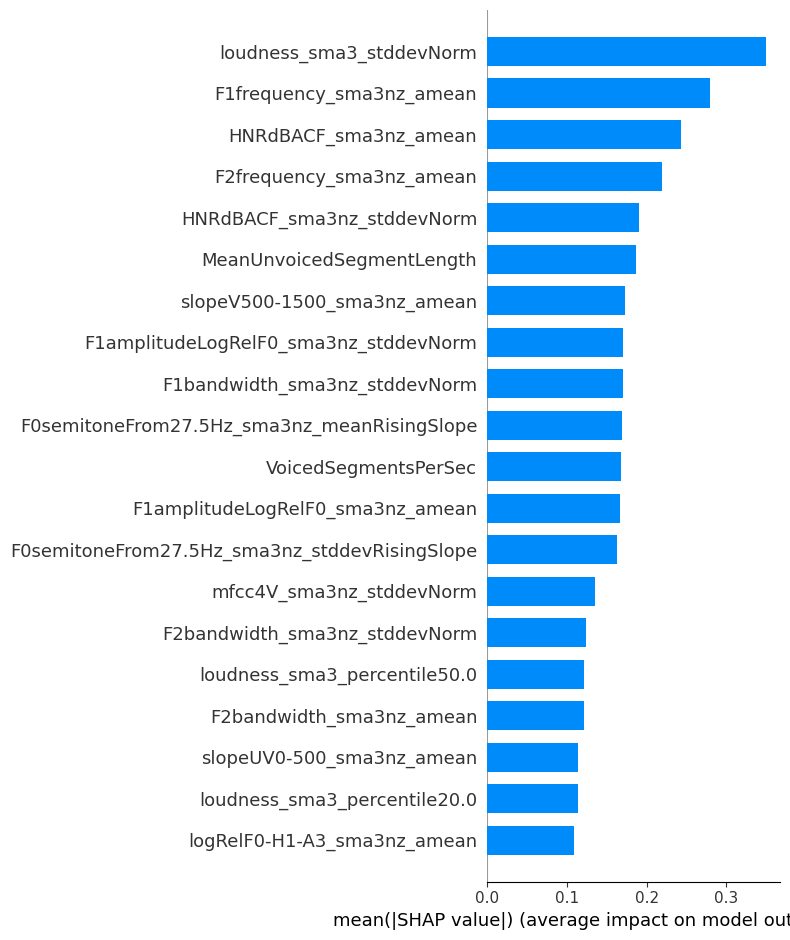

F1: 86.3


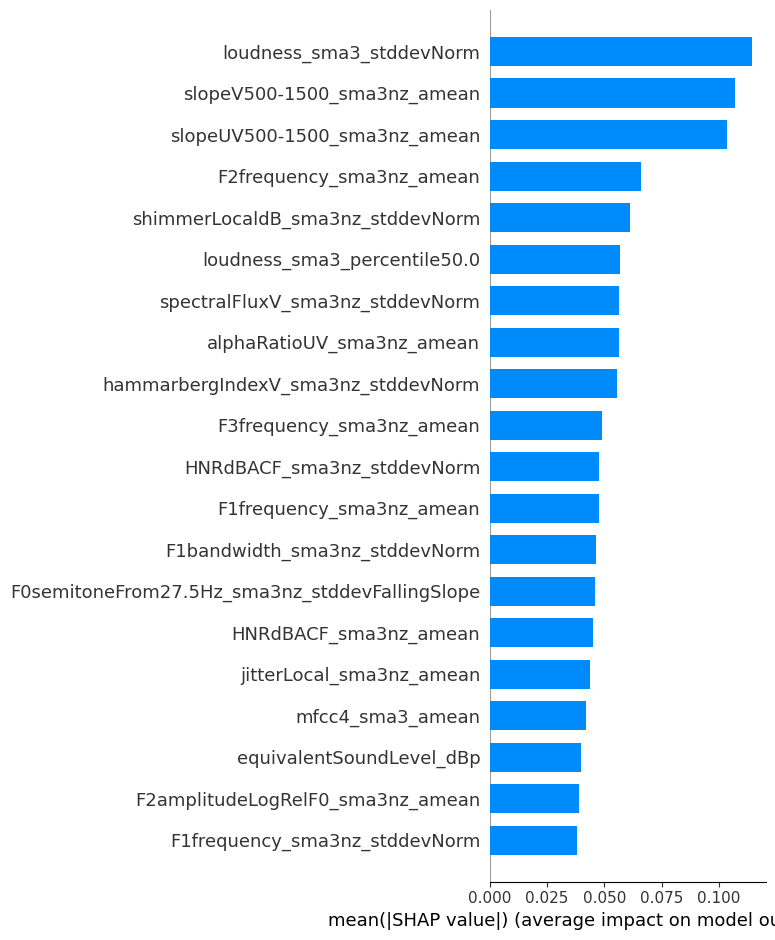

In [19]:
eGeMAPS_fi_dict = {}
egemaps_top_features_df = {}

emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  ege_embeddings, ege_labels, ege_speakers = egemaps_embeddings_all[e], labels_all[e], speakers_all[e]
  trained_model, result = classification_pipeline(embeddings=ege_embeddings, speakers=ege_speakers, labels_list=ege_labels, feature_names=egemaps_feature_names)
  Performance['eGeMAPS'][e] = result

  fi = feature_importance_method(X=ege_embeddings, y=ege_labels, feature_names=egemaps_feature_names, trained_model=trained_model)
#   eGeMAPS_fi_dict[e] = [list(egemaps_feature_names).index(tup[0]) for tup in fi]
  eGeMAPS_top_fi_features = [[tup[0], np.round(tup[1], 3)] for tup in fi]
  table = {'Feature': [element[0] for element in eGeMAPS_top_fi_features], 'Importance': [element[1] for element in eGeMAPS_top_fi_features]}
  egemaps_top_features_df[e] = pd.DataFrame(table)


## Most important egemaps features (according to coef)

In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def process_and_save_egemaps_data(egemaps_top_features_df, egemaps_category_dict, output_dir):
    scaler = MinMaxScaler(feature_range=(0, 1))  # For normalizing importance values

    # Loop through each emotion and process its DataFrame
    for emotion, df in egemaps_top_features_df.items():
        # Map features to their categories
        df['Category'] = df['Feature'].map(egemaps_category_dict)

        # Normalize the Importance values
        df['Importance'] = scaler.fit_transform(df[['Importance']])

        # Save the processed DataFrame as a pickle file
        output_path = f'{output_dir}/{emotion}_ravdess_processed.pkl'
        df.to_pickle(output_path)
        print(f'Saved: {output_path}')


In [21]:
egemaps_category_dict = {
    'F0semitoneFrom27.5Hz_sma3nz_amean': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile20.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile50.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile80.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope': 'Frequency',
    'jitterLocal_sma3nz_amean': 'Frequency',
    'jitterLocal_sma3nz_stddevNorm': 'Frequency',
    'shimmerLocaldB_sma3nz_amean': 'Energy',
    'shimmerLocaldB_sma3nz_stddevNorm': 'Energy',
    'loudness_sma3_amean': 'Energy',
    'loudness_sma3_stddevNorm': 'Energy',
    'loudness_sma3_percentile20.0': 'Energy',
    'loudness_sma3_percentile50.0': 'Energy',
    'loudness_sma3_percentile80.0': 'Energy',
    'loudness_sma3_pctlrange0-2': 'Energy',
    'loudness_sma3_meanRisingSlope': 'Energy',
    'loudness_sma3_stddevRisingSlope': 'Energy',
    'loudness_sma3_meanFallingSlope': 'Energy',
    'loudness_sma3_stddevFallingSlope': 'Energy',
    'HNRdBACF_sma3nz_amean': 'Energy',
    'HNRdBACF_sma3nz_stddevNorm': 'Energy',
    'spectralFlux_sma3_amean': 'Spectral',
    'spectralFlux_sma3_stddevNorm': 'Spectral',
    'mfcc1_sma3_amean': 'Spectral',
    'mfcc1_sma3_stddevNorm': 'Spectral',
    'mfcc2_sma3_amean': 'Spectral',
    'mfcc2_sma3_stddevNorm': 'Spectral',
    'mfcc3_sma3_amean': 'Spectral',
    'mfcc3_sma3_stddevNorm': 'Spectral',
    'mfcc4_sma3_amean': 'Spectral',
    'mfcc4_sma3_stddevNorm': 'Spectral',
    'logRelF0-H1-H2_sma3nz_amean': 'Spectral',
    'logRelF0-H1-H2_sma3nz_stddevNorm': 'Spectral',
    'logRelF0-H1-A3_sma3nz_amean': 'Spectral',
    'logRelF0-H1-A3_sma3nz_stddevNorm': 'Spectral',
    'F1frequency_sma3nz_amean': 'Frequency',
    'F1frequency_sma3nz_stddevNorm': 'Frequency',
    'F1bandwidth_sma3nz_amean': 'Frequency',
    'F1bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F1amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F1amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F2frequency_sma3nz_amean': 'Frequency',
    'F2frequency_sma3nz_stddevNorm': 'Frequency',
    'F2bandwidth_sma3nz_amean': 'Frequency',
    'F2bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F2amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F2amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F3frequency_sma3nz_amean': 'Frequency',
    'F3frequency_sma3nz_stddevNorm': 'Frequency',
    'F3bandwidth_sma3nz_amean': 'Frequency',
    'F3bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F3amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F3amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioV_sma3nz_amean': 'Spectral',
    'alphaRatioV_sma3nz_stddevNorm': 'Spectral',
    'hammarbergIndexV_sma3nz_amean': 'Spectral',
    'hammarbergIndexV_sma3nz_stddevNorm': 'Spectral',
    'slopeV0-500_sma3nz_amean': 'Spectral',
    'slopeV0-500_sma3nz_stddevNorm': 'Spectral',
    'slopeV500-1500_sma3nz_amean': 'Spectral',
    'slopeV500-1500_sma3nz_stddevNorm': 'Spectral',
    'spectralFluxV_sma3nz_amean': 'Spectral',
    'spectralFluxV_sma3nz_stddevNorm': 'Spectral',
    'mfcc1V_sma3nz_amean': 'Spectral',
    'mfcc1V_sma3nz_stddevNorm': 'Spectral',
    'mfcc2V_sma3nz_amean': 'Spectral',
    'mfcc2V_sma3nz_stddevNorm': 'Spectral',
    'mfcc3V_sma3nz_amean': 'Spectral',
    'mfcc3V_sma3nz_stddevNorm': 'Spectral',
    'mfcc4V_sma3nz_amean': 'Spectral',
    'mfcc4V_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioUV_sma3nz_amean': 'Spectral',
    'hammarbergIndexUV_sma3nz_amean': 'Spectral',
    'slopeUV0-500_sma3nz_amean': 'Spectral',
    'slopeUV500-1500_sma3nz_amean': 'Spectral',
    'spectralFluxUV_sma3nz_amean': 'Spectral',
    'loudnessPeaksPerSec': 'Temporal',
    'VoicedSegmentsPerSec': 'Temporal',
    'MeanVoicedSegmentLengthSec': 'Temporal',
    'StddevVoicedSegmentLengthSec': 'Temporal',
    'MeanUnvoicedSegmentLength': 'Temporal',
    'StddevUnvoicedSegmentLength': 'Temporal',
    'equivalentSoundLevel_dBp': 'Energy',
}

In [22]:
output_directory = '.'  # Replace with your desired output directory
process_and_save_egemaps_data(egemaps_top_features_df, egemaps_category_dict, output_directory)

Saved: ./anger_ravdess_processed.pkl
Saved: ./fear_ravdess_processed.pkl
Saved: ./neutrality_ravdess_processed.pkl
Saved: ./joy_ravdess_processed.pkl
Saved: ./sadness_ravdess_processed.pkl
Saved: ./disgust_ravdess_processed.pkl


In [23]:
df = egemaps_top_features_df[emotions[0]]
df.head(10)


,Feature,Importance,Category
0,equivalentSoundLevel_dBp,1.000000,Energy
1,slopeUV500-1500_sma3nz_amean,0.796460,Spectral
2,loudness_sma3_meanRisingSlope,0.778761,Energy
3,loudness_sma3_stddevFallingSlope,0.769912,Energy
4,loudness_sma3_stddevRisingSlope,0.769912,Energy
5,loudness_sma3_amean,0.707965,Energy
6,spectralFluxUV_sma3nz_amean,0.707965,Spectral
7,F2bandwidth_sma3nz_amean,0.681416,Frequency
8,hammarbergIndexV_sma3nz_amean,0.672566,Spectral
9,loudness_sma3_meanFallingSlope,0.672566,Energy


In [24]:
df = egemaps_top_features_df[emotions[1]]
df.head(10)


,Feature,Importance,Category
0,mfcc1_sma3_amean,1.000000,Spectral
1,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.712575,Frequency
2,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.650299,Frequency
3,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,0.641916,Frequency
4,F0semitoneFrom27.5Hz_sma3nz_amean,0.637126,Frequency
5,F1bandwidth_sma3nz_stddevNorm,0.621557,Frequency
6,F2frequency_sma3nz_stddevNorm,0.582036,Frequency
7,loudness_sma3_stddevNorm,0.558084,Energy
8,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,0.529341,Frequency
9,alphaRatioUV_sma3nz_amean,0.514970,Spectral


In [25]:
df = egemaps_top_features_df[emotions[2]]
df.head(10)


,Feature,Importance,Category
0,equivalentSoundLevel_dBp,0.0,Energy
1,StddevUnvoicedSegmentLength,0.0,Temporal
2,mfcc1_sma3_stddevNorm,0.0,Spectral
3,mfcc2_sma3_amean,0.0,Spectral
4,mfcc2_sma3_stddevNorm,0.0,Spectral
5,mfcc3_sma3_amean,0.0,Spectral
6,mfcc3_sma3_stddevNorm,0.0,Spectral
7,mfcc4_sma3_amean,0.0,Spectral
8,mfcc4_sma3_stddevNorm,0.0,Spectral
9,jitterLocal_sma3nz_amean,0.0,Frequency


In [26]:
df = egemaps_top_features_df[emotions[3]]
df.head(10)


,Feature,Importance,Category
0,equivalentSoundLevel_dBp,1.000000,Energy
1,F3bandwidth_sma3nz_stddevNorm,0.795144,Frequency
2,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,0.688923,Frequency
3,F0semitoneFrom27.5Hz_sma3nz_amean,0.678300,Frequency
4,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,0.640364,Frequency
5,hammarbergIndexV_sma3nz_stddevNorm,0.611533,Spectral
6,F1bandwidth_sma3nz_stddevNorm,0.556904,Frequency
7,F2bandwidth_sma3nz_stddevNorm,0.546282,Frequency
8,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,0.528073,Frequency
9,F1amplitudeLogRelF0_sma3nz_amean,0.488619,Spectral


In [27]:
df = egemaps_top_features_df[emotions[4]]
df.head(10)


,Feature,Importance,Category
0,loudness_sma3_stddevNorm,1.000000,Energy
1,F1frequency_sma3nz_amean,0.799427,Frequency
2,HNRdBACF_sma3nz_amean,0.693410,Energy
3,F2frequency_sma3nz_amean,0.624642,Frequency
4,HNRdBACF_sma3nz_stddevNorm,0.541547,Energy
5,MeanUnvoicedSegmentLength,0.532951,Temporal
6,slopeV500-1500_sma3nz_amean,0.492837,Spectral
7,F1amplitudeLogRelF0_sma3nz_stddevNorm,0.487106,Spectral
8,F1bandwidth_sma3nz_stddevNorm,0.487106,Frequency
9,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,0.481375,Frequency


In [28]:
df = egemaps_top_features_df[emotions[5]]
df.head(10)


,Feature,Importance,Category
0,loudness_sma3_stddevNorm,1.000000,Energy
1,slopeV500-1500_sma3nz_amean,0.929825,Spectral
2,slopeUV500-1500_sma3nz_amean,0.903509,Spectral
3,F2frequency_sma3nz_amean,0.570175,Frequency
4,shimmerLocaldB_sma3nz_stddevNorm,0.526316,Energy
5,loudness_sma3_percentile50.0,0.491228,Energy
6,spectralFluxV_sma3nz_stddevNorm,0.491228,Spectral
7,alphaRatioUV_sma3nz_amean,0.482456,Spectral
8,hammarbergIndexV_sma3nz_stddevNorm,0.482456,Spectral
9,F3frequency_sma3nz_amean,0.421053,Frequency


# Classification + SHAP for WavLM Embeddings
Results for emotion classification (binary classification task) using WavLM embeddings. Also includes results for calculating SHAP scores per feature for each emotion and identifying the number of top dimensions that results in optimal performance on the emotion classification task for every emotion. This is the size of the minimal set of dimensions for that particular emotion.

F1: 98.1


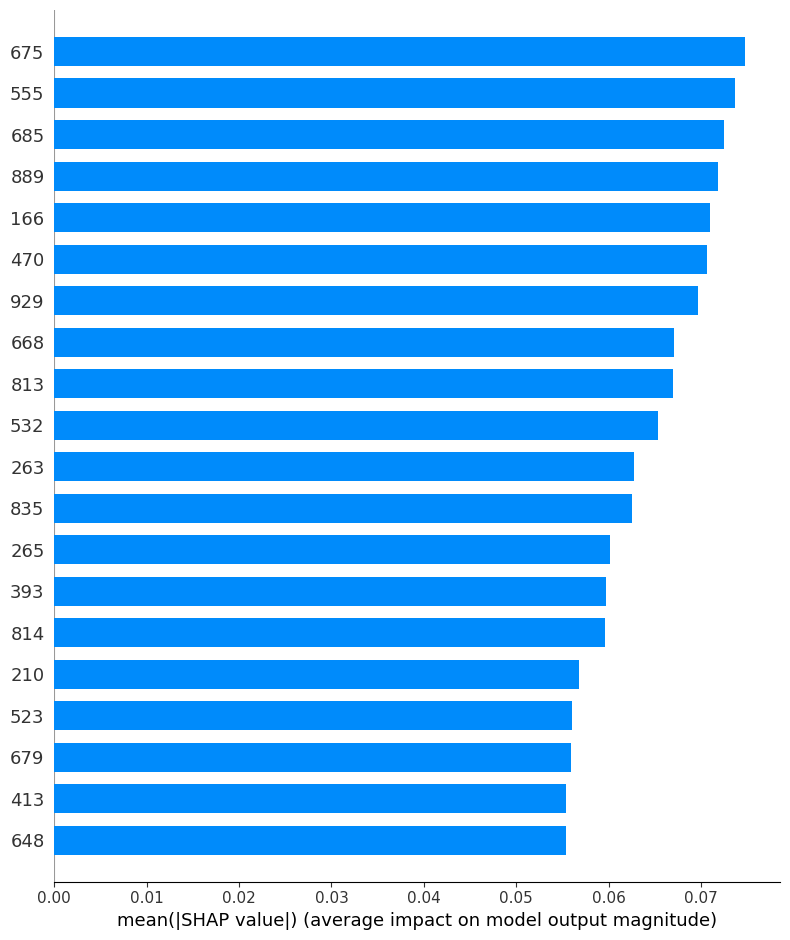

F1: 96.6


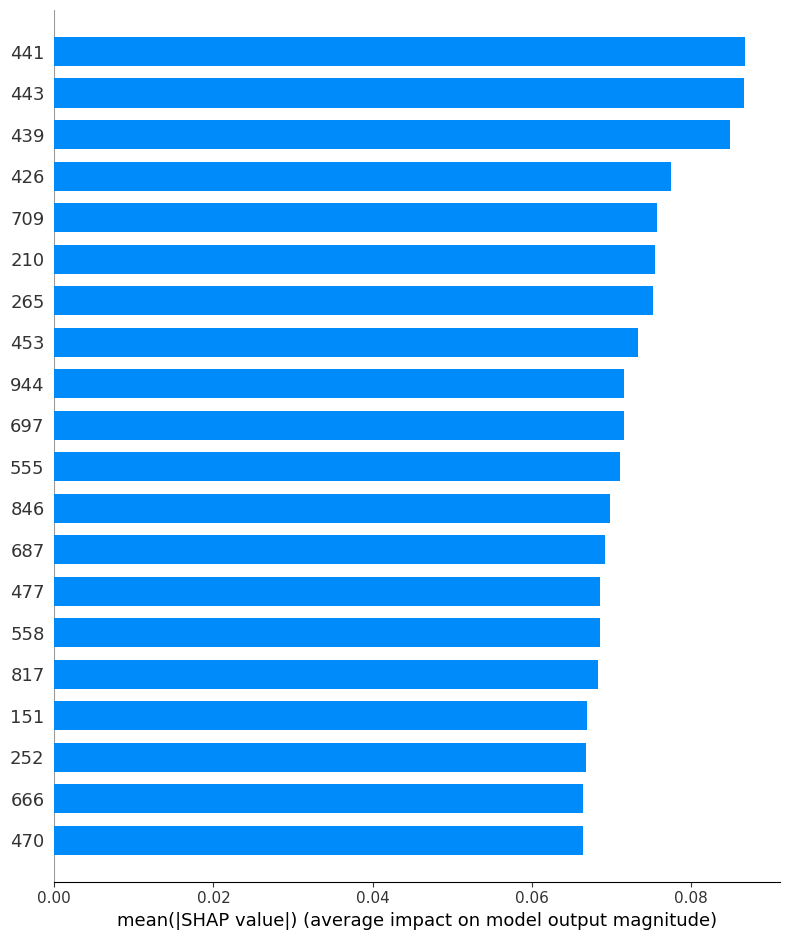

F1: 0.0


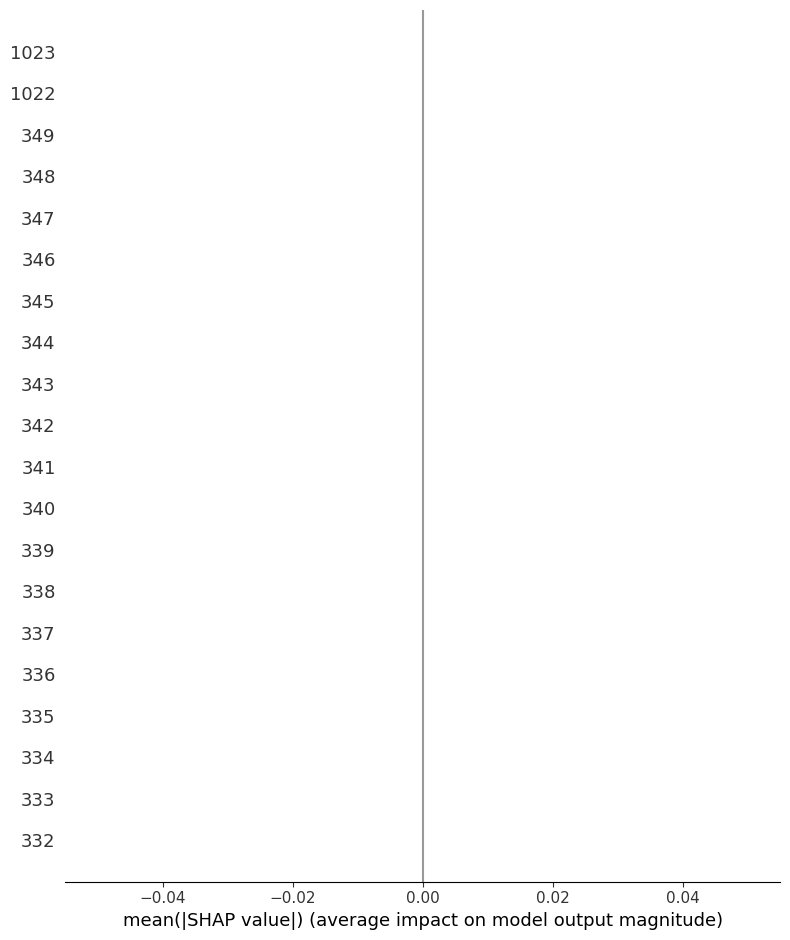

F1: 93.3


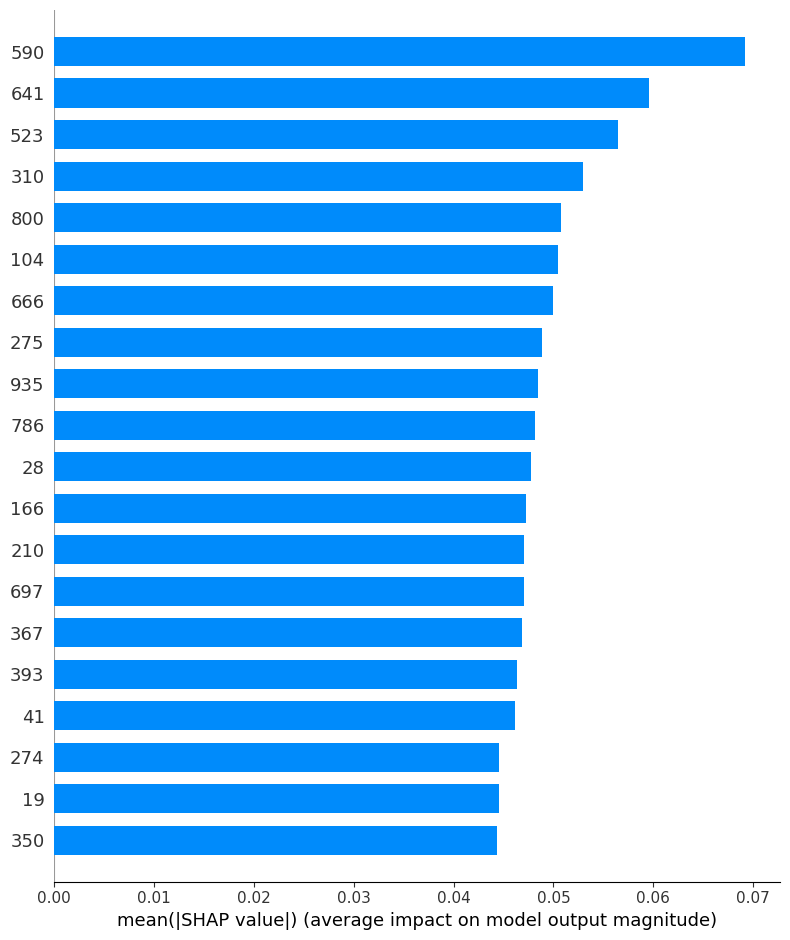

F1: 82.7


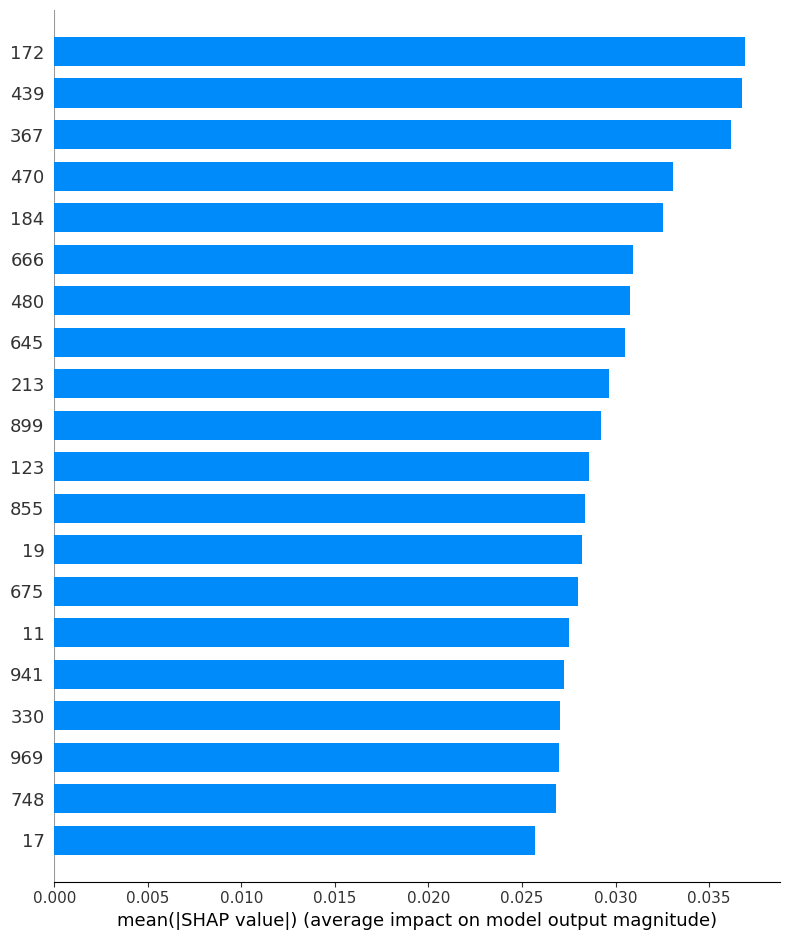

F1: 99.1


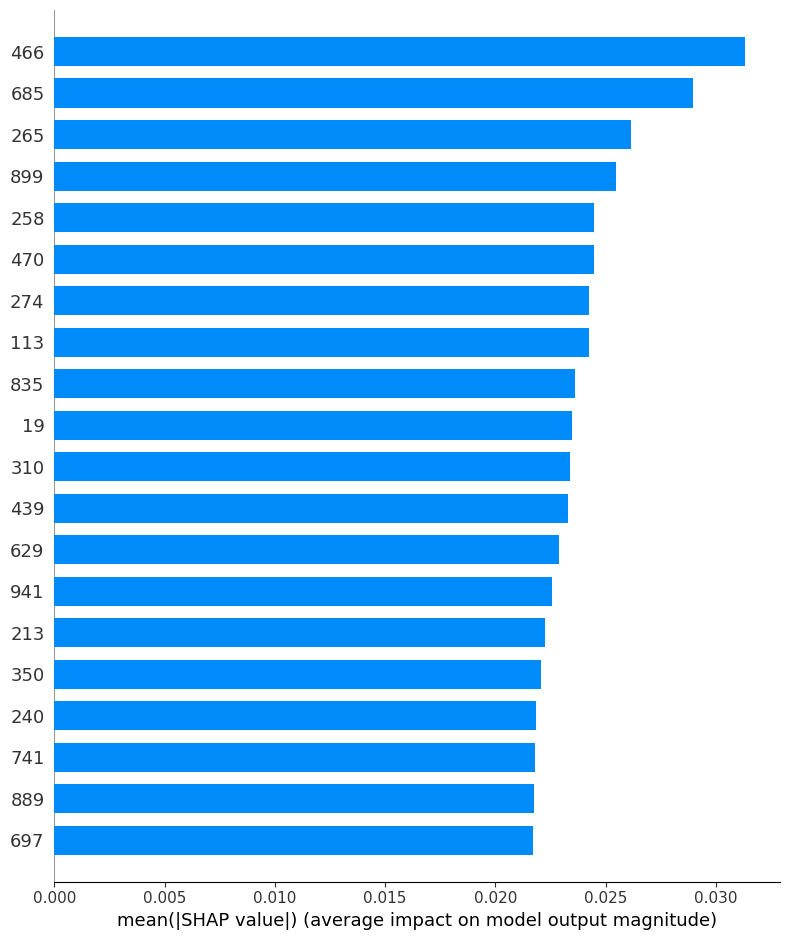

In [29]:
wavlm_feature_names = [i for i in range(1024)]
wavlm_fi_dict = {}
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']

for e in emotions:

  wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]

  trained_model, result = classification_pipeline(embeddings=wavlm_embeddings, speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
  Performance['WavLM_all'][e] = result

  fi = feature_importance_method(X=wavlm_embeddings, y=wavlm_labels, feature_names=wavlm_feature_names, trained_model=trained_model)
  wavlm_fi_dict[e] = [tup[0] for tup in fi]


In [30]:
num_wavlm_features = {e: 1 for e in emotions}

def plot_top_performance(e, importance_dict):
  wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]
  top_scores = []
  bottom_scores = []
  rest_scores = []

  total = 1024

  for n in range(10, int(total/2), 10):

    top_features = importance_dict[e][:n]
    best_model, top_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, top_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    top_scores.append(top_f1)

    rest_features = importance_dict[e][n+1:]
    best_model, rest_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, rest_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    rest_scores.append(rest_f1)

    bottom_features = importance_dict[e][total-n-1:]
    best_model, bottom_f1 = classification_pipeline(embeddings=wavlm_embeddings[:, bottom_features], speakers=wavlm_speakers, labels_list=wavlm_labels, feature_names=wavlm_feature_names)
    bottom_scores.append(bottom_f1)

  n_features = range(10, int(total/2), 10)
  fig, ax = plt.subplots(figsize=(12, 6))

  ax.plot(n_features, top_scores, label='Top dimensions')
  ax.plot(n_features, rest_scores, label='Rest dimensions')
  ax.plot(n_features, bottom_scores, label='Bottom dimensions')

  ax.set_xlabel('Number of dimensions')
  ax.set_ylabel('F1 score')
  ax.set_title(e)
  ax.legend()

  percentile = np.percentile(top_scores, 100)
  # ax.axhline(y=percentile, color='r')

  ax.set_ylim(20, 105)
  x_val = find_x_at_n_percentile(n_features, top_scores, 100)
  ax.scatter(x_val, percentile, marker='x', color='red')

  return x_val, percentile



## Plot top performance

{'anger': [675, 555, 685, 889, 166, 470, 929, 668, 813, 532, 263, 835, 265, 393, 814, 210, 523, 679, 413, 648, 321, 457, 644, 778, 267, 646, 741, 709, 819, 127, 597, 794, 385, 475, 353, 346, 816, 558, 907, 133, 240, 761, 944, 618, 344, 553, 124, 894, 310, 560, 189, 439, 799, 710, 417, 400, 619, 935, 687, 315, 352, 373, 39, 861, 404, 686, 62, 367, 88, 161, 796, 79, 783, 649, 524, 222, 495, 130, 476, 1002, 147, 516, 1021, 792, 563, 225, 931, 522, 447, 984, 526, 953, 416, 226, 233, 51, 942, 482, 200, 970, 1018, 30, 46, 950, 237, 502, 268, 562, 683, 904, 335, 150, 430, 24, 334, 195, 789, 536, 743, 779, 806, 469, 752, 220, 758, 633, 72, 357, 486, 291, 282, 1013, 135, 328, 635, 309, 589, 697, 880, 916, 989, 716, 120, 848, 930, 320, 113, 838, 82, 258, 988, 561, 616, 541, 403, 464, 71, 601, 603, 542, 800, 216, 249, 911, 896, 723, 424, 593, 631, 170, 203, 191, 824, 919, 306, 290, 937, 680, 348, 490, 1005, 629, 224, 453, 957, 692, 465, 89, 92, 455, 617, 793, 978, 382, 437, 231, 38, 504, 405, 398

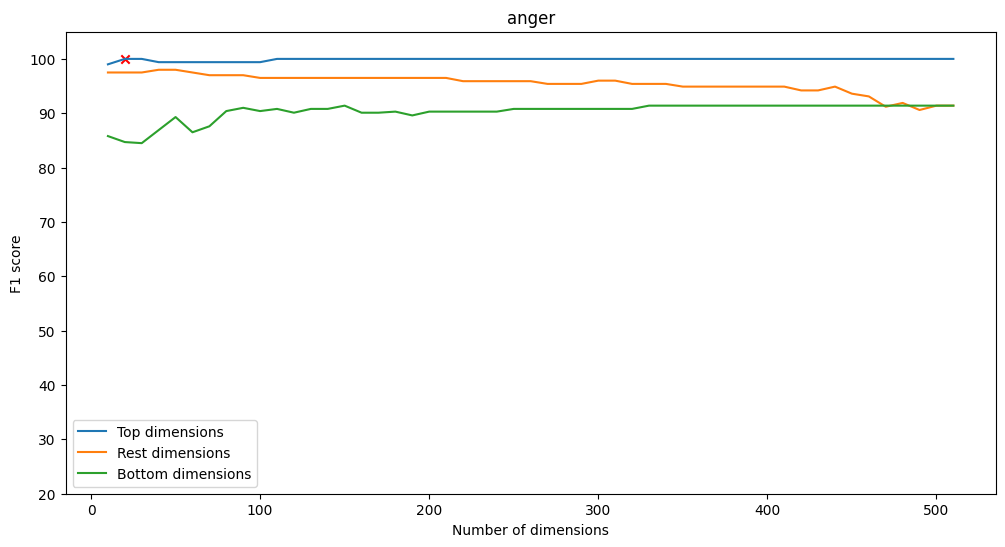

In [31]:
emotions = ['anger', 'fear', 'neutrality', 'joy', 'sadness', 'disgust']
print(wavlm_fi_dict)
num_wavlm_features[emotions[0]], Performance['WavLM_top_features'][emotions[0]] = plot_top_performance(emotions[0], wavlm_fi_dict)


F1: 98.2
F1: 96.1
F1: 82.4
F1: 97.8
F1: 96.1
F1: 87.4
F1: 98.2
F1: 97.4
F1: 88.8
F1: 98.2
F1: 96.9
F1: 88.4
F1: 98.2
F1: 96.9
F1: 89.5
F1: 98.2
F1: 96.8
F1: 88.8
F1: 98.2
F1: 96.1
F1: 90.7
F1: 98.2
F1: 96.7
F1: 89.9
F1: 98.2
F1: 97.4
F1: 90.0
F1: 98.2
F1: 97.4
F1: 90.0
F1: 99.0
F1: 96.7
F1: 90.0
F1: 98.2
F1: 96.9
F1: 89.4
F1: 98.2
F1: 96.1
F1: 90.0
F1: 98.7
F1: 95.2
F1: 91.9
F1: 98.2
F1: 95.7
F1: 90.6
F1: 98.2
F1: 96.5
F1: 90.6
F1: 98.2
F1: 96.5
F1: 90.6
F1: 98.2
F1: 95.2
F1: 90.6
F1: 98.2
F1: 95.2
F1: 90.7
F1: 98.2
F1: 94.7
F1: 90.6
F1: 98.2
F1: 94.2
F1: 92.5
F1: 98.2
F1: 94.7
F1: 92.5
F1: 98.2
F1: 93.0
F1: 92.5
F1: 98.2
F1: 93.0
F1: 92.5
F1: 98.2
F1: 93.1
F1: 92.5
F1: 98.2
F1: 94.7
F1: 90.2
F1: 98.2
F1: 94.2
F1: 92.5
F1: 98.2
F1: 92.5
F1: 92.5
F1: 98.2
F1: 94.2
F1: 91.7
F1: 98.2
F1: 94.2
F1: 92.5
F1: 98.2
F1: 93.7
F1: 91.7
F1: 98.2
F1: 94.4
F1: 92.5
F1: 98.2
F1: 93.7
F1: 91.7
F1: 98.2
F1: 93.7
F1: 92.5
F1: 98.2
F1: 94.2
F1: 92.5
F1: 98.2
F1: 93.7
F1: 92.5
F1: 98.2
F1: 93.7
F1: 92.5
F

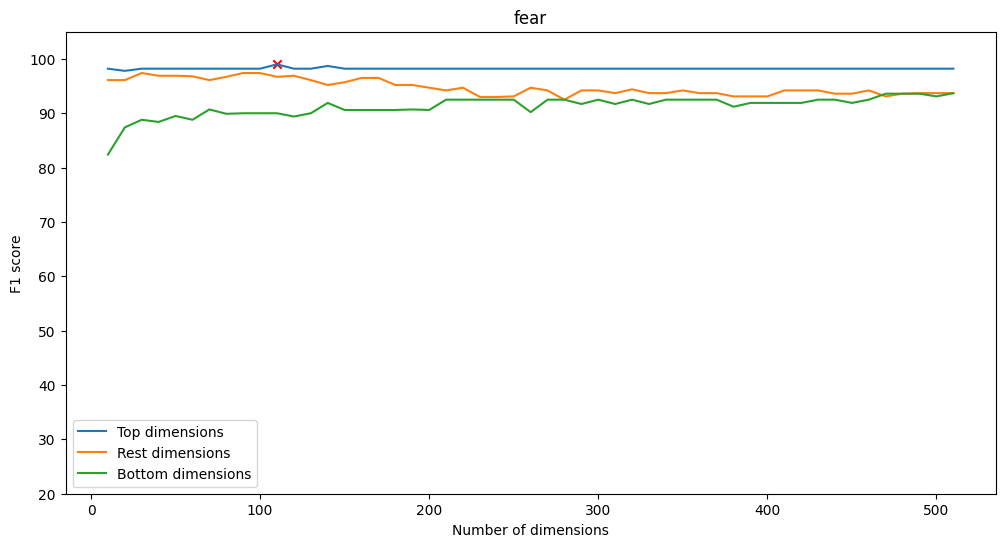

In [32]:

num_wavlm_features[emotions[1]], Performance['WavLM_top_features'][emotions[1]]  = plot_top_performance(emotions[1], wavlm_fi_dict)


F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0
F1: 0.0


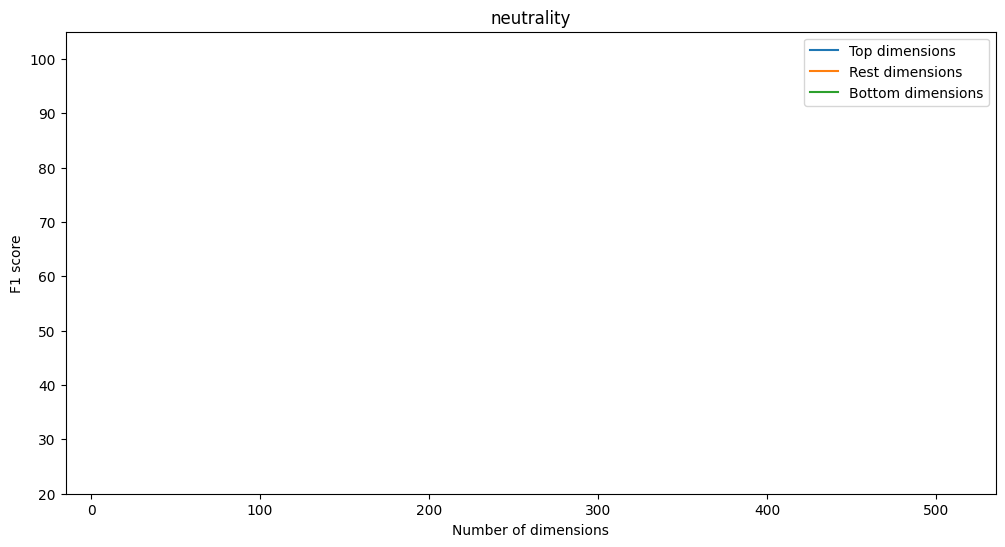

In [33]:

num_wavlm_features[emotions[2]], Performance['WavLM_top_features'][emotions[2]] = plot_top_performance(emotions[2], wavlm_fi_dict)


F1: 95.9
F1: 91.1
F1: 75.9
F1: 99.0
F1: 91.3
F1: 80.4
F1: 99.5
F1: 90.6
F1: 81.5
F1: 98.7
F1: 91.1
F1: 80.4
F1: 98.7
F1: 91.7
F1: 78.6
F1: 99.5
F1: 91.4
F1: 81.0
F1: 99.5
F1: 90.3
F1: 81.2
F1: 98.9
F1: 90.3
F1: 79.7
F1: 99.5
F1: 90.3
F1: 79.2
F1: 98.9
F1: 89.9
F1: 75.8
F1: 99.5
F1: 89.7
F1: 81.8
F1: 99.5
F1: 88.8
F1: 80.5
F1: 99.5
F1: 90.0
F1: 80.2
F1: 98.2
F1: 89.7
F1: 79.4
F1: 98.7
F1: 89.7
F1: 80.8
F1: 98.8
F1: 87.9
F1: 82.3
F1: 98.8
F1: 86.8
F1: 82.9
F1: 99.5
F1: 87.6
F1: 82.3
F1: 99.5
F1: 87.6
F1: 83.4
F1: 99.5
F1: 86.4
F1: 83.4
F1: 99.5
F1: 88.3
F1: 83.6
F1: 99.5
F1: 88.3
F1: 83.9
F1: 99.5
F1: 86.5
F1: 82.3
F1: 99.5
F1: 85.5
F1: 82.3
F1: 98.9
F1: 85.5
F1: 83.6
F1: 98.9
F1: 85.5
F1: 83.6
F1: 98.9
F1: 85.5
F1: 84.6
F1: 98.9
F1: 87.4
F1: 83.3
F1: 98.9
F1: 85.8
F1: 83.3
F1: 98.9
F1: 84.5
F1: 83.7
F1: 98.4
F1: 87.4
F1: 83.2
F1: 98.9
F1: 89.1
F1: 83.2
F1: 98.9
F1: 86.6
F1: 83.6
F1: 97.9
F1: 87.4
F1: 83.6
F1: 98.4
F1: 87.5
F1: 83.9
F1: 98.4
F1: 87.1
F1: 83.6
F1: 97.9
F1: 87.9
F1: 83.1
F

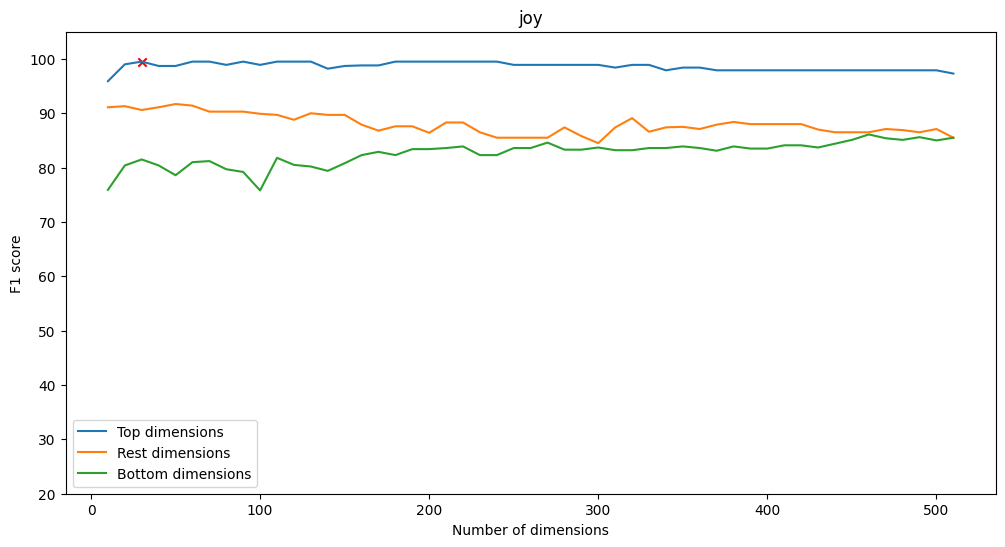

In [34]:

num_wavlm_features[emotions[3]], Performance['WavLM_top_features'][emotions[3]] = plot_top_performance(emotions[3], wavlm_fi_dict)


F1: 90.2
F1: 81.7
F1: 57.8
F1: 92.9
F1: 82.9
F1: 56.7
F1: 94.3
F1: 82.9
F1: 60.1
F1: 92.9
F1: 81.9
F1: 61.3
F1: 93.0
F1: 82.9
F1: 58.6
F1: 95.3
F1: 82.4
F1: 61.5
F1: 96.5
F1: 82.0
F1: 60.8
F1: 94.9
F1: 80.7
F1: 57.7
F1: 94.6
F1: 80.6
F1: 57.3
F1: 94.6
F1: 82.0
F1: 57.4
F1: 95.3
F1: 81.1
F1: 59.0
F1: 93.1
F1: 82.4
F1: 60.5
F1: 93.7
F1: 81.4
F1: 58.0
F1: 93.0
F1: 79.0
F1: 60.1
F1: 94.3
F1: 79.9
F1: 58.9
F1: 93.7
F1: 79.3
F1: 55.4
F1: 94.3
F1: 79.9
F1: 59.9
F1: 93.2
F1: 80.4
F1: 59.5
F1: 92.4
F1: 78.4
F1: 57.9
F1: 94.0
F1: 78.4
F1: 57.9
F1: 92.2
F1: 78.4
F1: 58.9
F1: 91.8
F1: 78.4
F1: 59.2
F1: 91.1
F1: 78.4
F1: 59.4
F1: 91.6
F1: 77.4
F1: 58.4
F1: 92.2
F1: 76.3
F1: 59.2
F1: 92.2
F1: 76.3
F1: 60.9
F1: 91.8
F1: 76.0
F1: 61.0
F1: 92.4
F1: 76.1
F1: 60.9
F1: 93.0
F1: 75.8
F1: 59.7
F1: 93.0
F1: 75.4
F1: 59.6
F1: 92.4
F1: 75.4
F1: 59.5
F1: 91.1
F1: 75.1
F1: 61.0
F1: 91.1
F1: 75.4
F1: 60.8
F1: 91.8
F1: 74.7
F1: 59.9
F1: 90.7
F1: 74.0
F1: 60.2
F1: 91.2
F1: 73.0
F1: 60.7
F1: 91.7
F1: 71.3
F1: 60.3
F

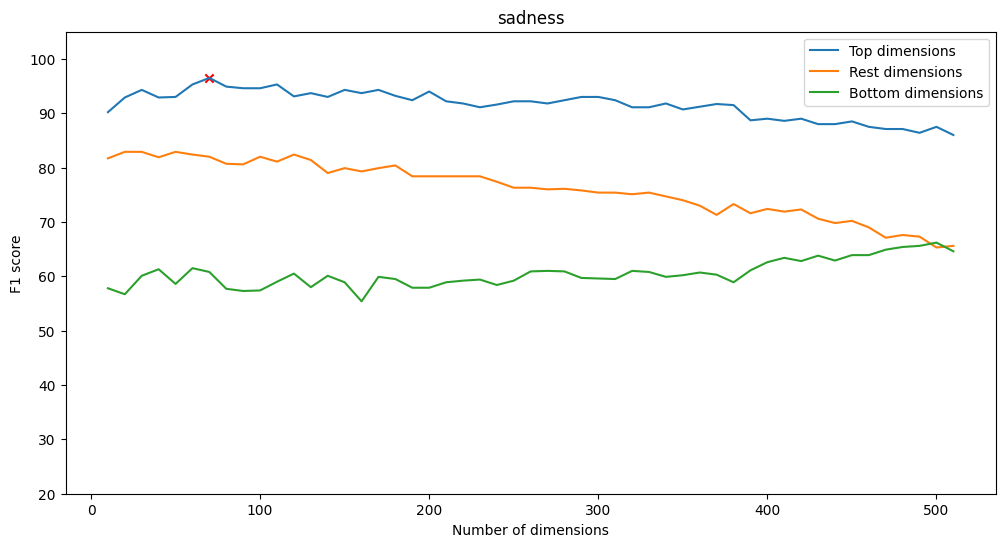

In [35]:

num_wavlm_features[emotions[4]], Performance['WavLM_top_features'][emotions[4]] = plot_top_performance(emotions[4], wavlm_fi_dict)


F1: 100.0
F1: 99.1
F1: 64.4
F1: 99.1
F1: 99.1
F1: 68.7
F1: 99.6
F1: 98.6
F1: 73.7
F1: 100.0
F1: 98.6
F1: 70.8
F1: 100.0
F1: 98.6
F1: 70.8
F1: 100.0
F1: 98.6
F1: 74.2
F1: 100.0
F1: 98.6
F1: 77.7
F1: 100.0
F1: 98.6
F1: 76.1
F1: 100.0
F1: 98.6
F1: 74.9
F1: 100.0
F1: 98.6
F1: 76.1
F1: 100.0
F1: 98.6
F1: 77.1
F1: 100.0
F1: 98.6
F1: 81.3
F1: 100.0
F1: 98.6
F1: 82.3
F1: 100.0
F1: 98.6
F1: 82.0
F1: 99.6
F1: 98.6
F1: 80.9
F1: 99.6
F1: 98.6
F1: 79.7
F1: 100.0
F1: 98.6
F1: 80.5
F1: 100.0
F1: 98.6
F1: 80.0
F1: 100.0
F1: 98.6
F1: 81.5
F1: 100.0
F1: 98.6
F1: 82.2
F1: 100.0
F1: 98.6
F1: 82.9
F1: 100.0
F1: 98.6
F1: 82.1
F1: 100.0
F1: 98.6
F1: 82.7
F1: 100.0
F1: 98.6
F1: 82.4
F1: 99.6
F1: 98.1
F1: 84.0
F1: 99.6
F1: 97.5
F1: 83.3
F1: 100.0
F1: 97.0
F1: 83.0
F1: 99.6
F1: 98.1
F1: 82.7
F1: 99.6
F1: 98.1
F1: 85.2
F1: 100.0
F1: 97.6
F1: 86.1
F1: 100.0
F1: 97.6
F1: 86.0
F1: 100.0
F1: 97.6
F1: 87.8
F1: 100.0
F1: 97.0
F1: 87.2
F1: 99.6
F1: 98.1
F1: 87.8
F1: 99.6
F1: 97.6
F1: 87.5
F1: 99.6
F1: 96.5
F1: 89.0
F1:

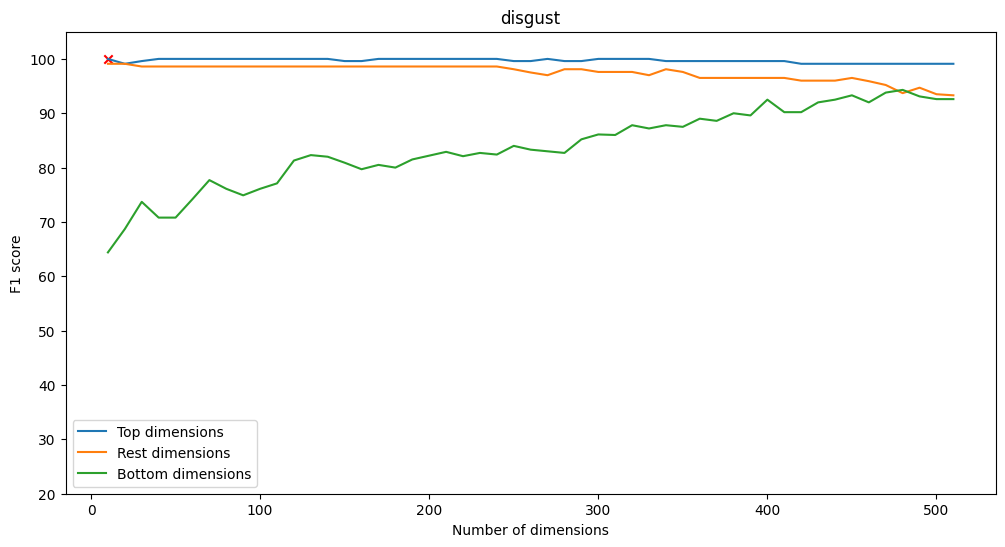

In [36]:

num_wavlm_features[emotions[5]], Performance['WavLM_top_features'][emotions[5]] = plot_top_performance(emotions[5], wavlm_fi_dict)


In [37]:
print(num_wavlm_features)


{'anger': 20, 'fear': 110, 'neutrality': 10, 'joy': 30, 'sadness': 70, 'disgust': 10}


# Regression + Metrics Code
Code for the regression task and evaluating metrics based on RMSE top and RMSE all for every eGeMAPS feature for each emotion

In [38]:
# Defining a function for all steps
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

def get_rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Defining a function for hyperparameter tuning and getting the accuracy on the test set
def get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring='neg_mean_squared_error'): # check scoring

    pipe = Pipeline([('scaler', StandardScaler()),('model', regressor)])

    grid = GridSearchCV(pipe, param_grid=parameters, cv=5, n_jobs=-1, scoring=scoring)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    rmse = get_rmse(y_test, y_pred)

    return rmse

def prediction_pipeline(labeled_array, labels_list, regression_model, scoring='neg_root_mean_squared_error'):

  X_train, X_test, y_train, y_test = train_test_split(labeled_array, labels_list, test_size=0.20)

  if regression_model == 'ridge':
    regressor = Ridge()
    parameters = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
    rmse = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  return rmse

In [39]:
def weighted_difference_rmse(RMSE_all, RMSE_top):
  # Performance change: this metric effectively captures both the magnitude and direction of change. The numerator emphasizes proportional change, while the denominator adjusts for the scale of RMSE values, ensuring that the metric is sensitive to relative improvement or degradation.
  # Weighting: based on the average RMSE, which balances the influence of both before and after performance. This approach somewhat weights the performance, favoring models with overall lower RMSE values. However, it might not strongly emphasize absolute performance post-change as the average RMSE dilutes this effect.
    change_ratio = (RMSE_top - RMSE_all) / RMSE_all
    average_rmse = (RMSE_all + RMSE_top) / 2
    return change_ratio * (1 / average_rmse)

def harmonic_mean_metric(RMSE_all, RMSE_top):
  # Performance change: This metric combines improvement rate and performance rate in a balanced manner, ensuring that both aspects are equally important. It's particularly sensitive to scenarios where both improvement and post-change performance are strong but doesn't favor one excessively over the other.
  # Weighting: The harmonic mean inherently gives equal weight to improvement and post-change performance. This method ensures that a high score requires both significant improvement and strong performance, making it a balanced choice between change and performance weighting.
    improvement_rate = RMSE_all / RMSE_top
    performance_rate = 1 / RMSE_top
    return 2 / ((1 / improvement_rate) + (1 / performance_rate))

def change_index_adjusted_performance(RMSE_all, RMSE_top):
  # Performance change: This metric clearly reflects proportional change. The exponential factor introduces a strong performance weighting, emphasizing the importance of lower RMSE values after the change.
  # Weighting: The exponential decay heavily weights the performance aspect, significantly favoring lower (better) RMSE values after the change. It's highly sensitive to post-change performance, potentially at the expense of recognizing substantial proportional improvements from a high baseline.
    change_ratio = RMSE_top / RMSE_all
    performance_factor = np.exp(-RMSE_top)
    return change_ratio * performance_factor

def performance_weighted_change_score(RMSE_all, RMSE_top):
  # Performance change: This formula directly quantifies the improvement in RMSE and scales it by the inverse of the post-change RMSE, making it sensitive to both the direction and scale of change
  # Weighting: By inversely scaling by RMSEafter, this metric places a significant emphasis on post-change performance. The better the performance (i.e., the lower the RMSE after), the higher the metric value, making it strongly performance-weighted.
    return (RMSE_all - RMSE_top) * (1 / RMSE_top)

In [40]:
predicted_df_dict = {}

import numpy as np

def top_wavlm_predict_ege(e):
    rmse_top_list = []
    rmse_all_list = []
    rmse_top_all = []
    rmse_top_squared_all = []
    weighted_difference_rmse_all = []
    harmonic_mean_metric_all = []
    change_index_adjusted_performance_all = []
    performance_weighted_change_score_all = []

    wavlm_embeddings, wavlm_labels, wavlm_speakers = wavlm_embeddings_all[e], labels_all[e], speakers_all[e]
    ege_embeddings, ege_labels, ege_speakers = egemaps_embeddings_all[e], labels_all[e], speakers_all[e]

    top_features = wavlm_fi_dict[e][:num_wavlm_features[e]]
    all_features = wavlm_fi_dict[e][:]

    for i in tqdm(range(88)):
        rmse_top = prediction_pipeline(wavlm_embeddings[:, top_features], ege_embeddings[:,i], regression_model='ridge')
        rmse_all = prediction_pipeline(wavlm_embeddings[:, all_features], ege_embeddings[:,i], regression_model='ridge')
        rmse_top_list.append(np.round(rmse_top, 3))
        rmse_all_list.append(np.round(rmse_all, 3))
        rmse_top_all.append(np.round(rmse_top/rmse_all, 3))
        rmse_top_squared_all.append(np.round(rmse_top**2/rmse_all, 3))

        # Calculate additional metrics
        weighted_difference_rmse_all.append(np.round(weighted_difference_rmse(rmse_all, rmse_top), 3))
        harmonic_mean_metric_all.append(np.round(harmonic_mean_metric(rmse_all, rmse_top), 3))
        change_index_adjusted_performance_all.append(np.round(change_index_adjusted_performance(rmse_all, rmse_top), 3))
        performance_weighted_change_score_all.append(np.round(performance_weighted_change_score(rmse_all, rmse_top), 3))

    prediction_metrics_dict = {
        'Feature': egemaps_feature_names,
        'rmse_top_all': rmse_top_all,
        'rmse_top_squared_all': rmse_top_squared_all,
        'rmse_top': rmse_top_list,
        'rmse_all': rmse_all_list,
        'weighted_difference_rmse_all': weighted_difference_rmse_all,
        'harmonic_mean_metric_all': harmonic_mean_metric_all,
        'change_index_adjusted_performance_all': change_index_adjusted_performance_all,
        'performance_weighted_change_score_all': performance_weighted_change_score_all
    }
    return prediction_metrics_dict




# Regression + Metrics Results
Metrics for Each EgeMAPS Feature For All Emotions

## Anger

In [41]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[0]))
sorted_df = df.sort_values(by='rmse_top_all', ascending=True)
predicted_df_dict[emotions[0]] = sorted_df


  0%|          | 0/88 [00:00<?, ?it/s]/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.65979e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.56989e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.54006e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.61773e-08): result may not be accurate.
  dual

In [42]:
sorted_df.head(30)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
37,logRelF0-H1-H2_sma3nz_stddevNorm,0.509,0.386,0.757,1.487,-0.437,1.579,0.239,0.963
25,mfcc2_sma3_stddevNorm,0.535,0.302,0.564,1.055,-0.575,1.820,0.304,0.870
65,slopeV500-1500_sma3nz_stddevNorm,0.587,0.386,0.658,1.121,-0.464,1.606,0.304,0.704
43,F1bandwidth_sma3nz_stddevNorm,0.675,0.367,0.543,0.804,-0.482,1.641,0.392,0.480
8,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,0.687,0.359,0.523,0.761,-0.488,1.653,0.407,0.456
27,mfcc3_sma3_stddevNorm,0.711,0.854,1.201,1.688,-0.200,1.046,0.214,0.406
71,mfcc2V_sma3nz_stddevNorm,0.716,0.515,0.719,1.005,-0.330,1.394,0.349,0.397
5,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,0.722,0.422,0.584,0.809,-0.399,1.531,0.403,0.384
76,alphaRatioUV_sma3nz_amean,0.736,0.502,0.682,0.926,-0.328,1.410,0.372,0.359
53,F3frequency_sma3nz_stddevNorm,0.756,0.581,0.768,1.016,-0.274,1.312,0.351,0.323


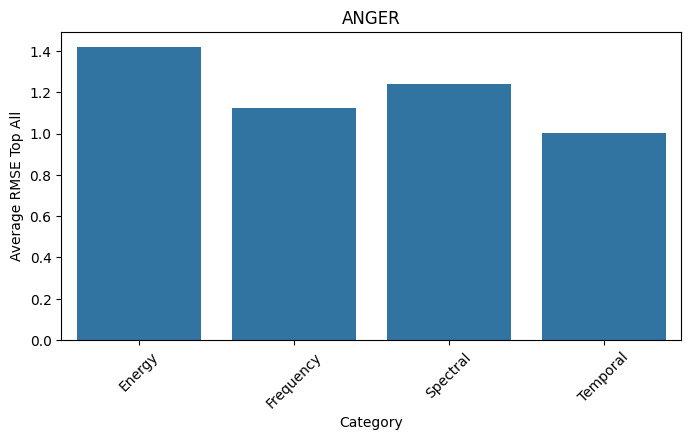

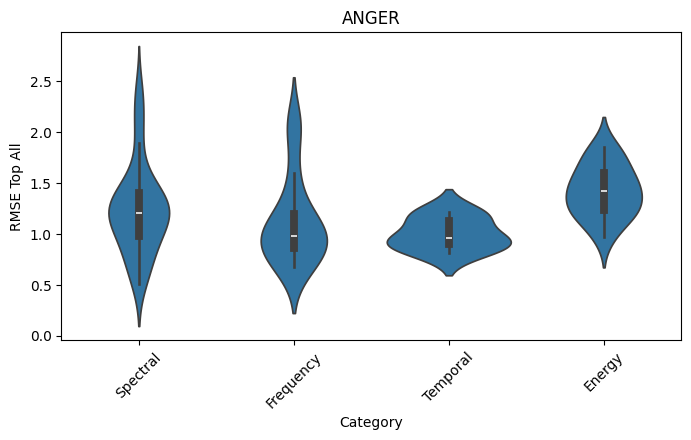

In [43]:
import pandas as pd

# Assuming the dictionary and sorted_df are already defined
# Define the dictionary
egemaps_category_dict = {
    'F0semitoneFrom27.5Hz_sma3nz_amean': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile20.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile50.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_percentile80.0': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope': 'Frequency',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope': 'Frequency',
    'jitterLocal_sma3nz_amean': 'Frequency',
    'jitterLocal_sma3nz_stddevNorm': 'Frequency',
    'shimmerLocaldB_sma3nz_amean': 'Energy',
    'shimmerLocaldB_sma3nz_stddevNorm': 'Energy',
    'loudness_sma3_amean': 'Energy',
    'loudness_sma3_stddevNorm': 'Energy',
    'loudness_sma3_percentile20.0': 'Energy',
    'loudness_sma3_percentile50.0': 'Energy',
    'loudness_sma3_percentile80.0': 'Energy',
    'loudness_sma3_pctlrange0-2': 'Energy',
    'loudness_sma3_meanRisingSlope': 'Energy',
    'loudness_sma3_stddevRisingSlope': 'Energy',
    'loudness_sma3_meanFallingSlope': 'Energy',
    'loudness_sma3_stddevFallingSlope': 'Energy',
    'HNRdBACF_sma3nz_amean': 'Energy',
    'HNRdBACF_sma3nz_stddevNorm': 'Energy',
    'spectralFlux_sma3_amean': 'Spectral',
    'spectralFlux_sma3_stddevNorm': 'Spectral',
    'mfcc1_sma3_amean': 'Spectral',
    'mfcc1_sma3_stddevNorm': 'Spectral',
    'mfcc2_sma3_amean': 'Spectral',
    'mfcc2_sma3_stddevNorm': 'Spectral',
    'mfcc3_sma3_amean': 'Spectral',
    'mfcc3_sma3_stddevNorm': 'Spectral',
    'mfcc4_sma3_amean': 'Spectral',
    'mfcc4_sma3_stddevNorm': 'Spectral',
    'logRelF0-H1-H2_sma3nz_amean': 'Spectral',
    'logRelF0-H1-H2_sma3nz_stddevNorm': 'Spectral',
    'logRelF0-H1-A3_sma3nz_amean': 'Spectral',
    'logRelF0-H1-A3_sma3nz_stddevNorm': 'Spectral',
    'F1frequency_sma3nz_amean': 'Frequency',
    'F1frequency_sma3nz_stddevNorm': 'Frequency',
    'F1bandwidth_sma3nz_amean': 'Frequency',
    'F1bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F1amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F1amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F2frequency_sma3nz_amean': 'Frequency',
    'F2frequency_sma3nz_stddevNorm': 'Frequency',
    'F2bandwidth_sma3nz_amean': 'Frequency',
    'F2bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F2amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F2amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'F3frequency_sma3nz_amean': 'Frequency',
    'F3frequency_sma3nz_stddevNorm': 'Frequency',
    'F3bandwidth_sma3nz_amean': 'Frequency',
    'F3bandwidth_sma3nz_stddevNorm': 'Frequency',
    'F3amplitudeLogRelF0_sma3nz_amean': 'Spectral',
    'F3amplitudeLogRelF0_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioV_sma3nz_amean': 'Spectral',
    'alphaRatioV_sma3nz_stddevNorm': 'Spectral',
    'hammarbergIndexV_sma3nz_amean': 'Spectral',
    'hammarbergIndexV_sma3nz_stddevNorm': 'Spectral',
    'slopeV0-500_sma3nz_amean': 'Spectral',
    'slopeV0-500_sma3nz_stddevNorm': 'Spectral',
    'slopeV500-1500_sma3nz_amean': 'Spectral',
    'slopeV500-1500_sma3nz_stddevNorm': 'Spectral',
    'spectralFluxV_sma3nz_amean': 'Spectral',
    'spectralFluxV_sma3nz_stddevNorm': 'Spectral',
    'mfcc1V_sma3nz_amean': 'Spectral',
    'mfcc1V_sma3nz_stddevNorm': 'Spectral',
    'mfcc2V_sma3nz_amean': 'Spectral',
    'mfcc2V_sma3nz_stddevNorm': 'Spectral',
    'mfcc3V_sma3nz_amean': 'Spectral',
    'mfcc3V_sma3nz_stddevNorm': 'Spectral',
    'mfcc4V_sma3nz_amean': 'Spectral',
    'mfcc4V_sma3nz_stddevNorm': 'Spectral',
    'alphaRatioUV_sma3nz_amean': 'Spectral',
    'hammarbergIndexUV_sma3nz_amean': 'Spectral',
    'slopeUV0-500_sma3nz_amean': 'Spectral',
    'slopeUV500-1500_sma3nz_amean': 'Spectral',
    'spectralFluxUV_sma3nz_amean': 'Spectral',
    'loudnessPeaksPerSec': 'Temporal',
    'VoicedSegmentsPerSec': 'Temporal',
    'MeanVoicedSegmentLengthSec': 'Temporal',
    'StddevVoicedSegmentLengthSec': 'Temporal',
    'MeanUnvoicedSegmentLength': 'Temporal',
    'StddevUnvoicedSegmentLength': 'Temporal',
    'equivalentSoundLevel_dBp': 'Energy',
}

# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()


# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()



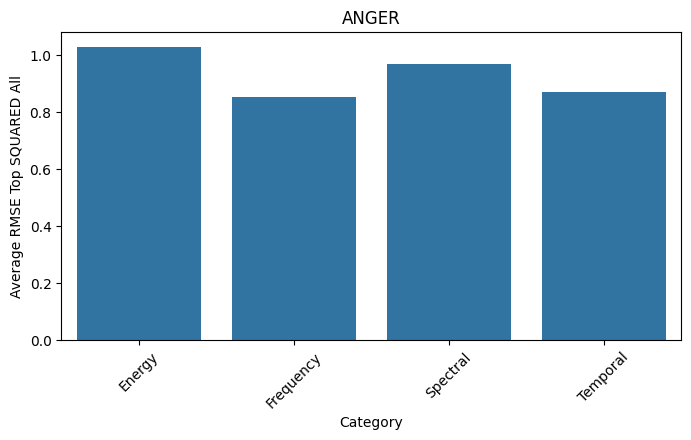

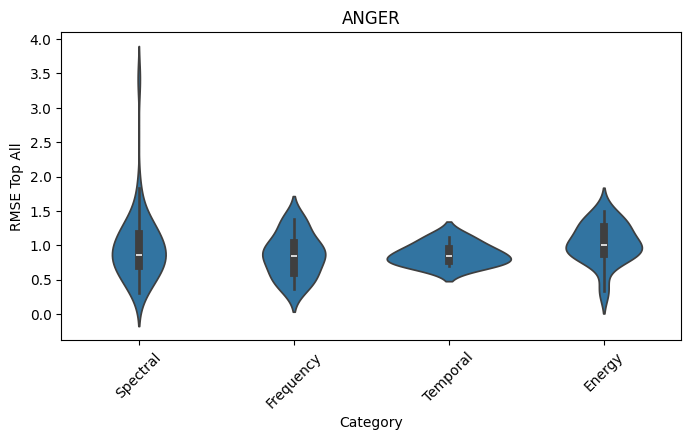

In [44]:
# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('anger_ravdess_infogain.pkl')

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('ANGER')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Fear

In [45]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[1]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[1]] = sorted_df


  0%|          | 0/88 [00:00<?, ?it/s]/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.33358e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.32819e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.7475e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.54696e-08): result may not be accurate.
  dual_

In [46]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
87,equivalentSoundLevel_dBp,1.151,0.267,0.232,0.202,0.694,1.446,0.912,-0.131
30,jitterLocal_sma3nz_amean,0.716,0.312,0.436,0.609,-0.545,1.737,0.463,0.398
16,loudness_sma3_meanRisingSlope,0.912,0.339,0.371,0.407,-0.227,1.559,0.629,0.097
7,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,0.656,0.357,0.544,0.830,-0.501,1.667,0.381,0.524
18,loudness_sma3_meanFallingSlope,0.902,0.359,0.398,0.442,-0.234,1.538,0.606,0.109
27,mfcc3_sma3_stddevNorm,0.624,0.366,0.587,0.942,-0.492,1.651,0.347,0.603
65,slopeV500-1500_sma3nz_stddevNorm,0.620,0.381,0.614,0.991,-0.474,1.621,0.335,0.614
17,loudness_sma3_stddevRisingSlope,0.917,0.386,0.421,0.459,-0.188,1.494,0.602,0.090
61,hammarbergIndexV_sma3nz_stddevNorm,0.685,0.387,0.565,0.825,-0.453,1.599,0.389,0.460
29,mfcc4_sma3_stddevNorm,0.753,0.397,0.527,0.701,-0.403,1.563,0.444,0.329


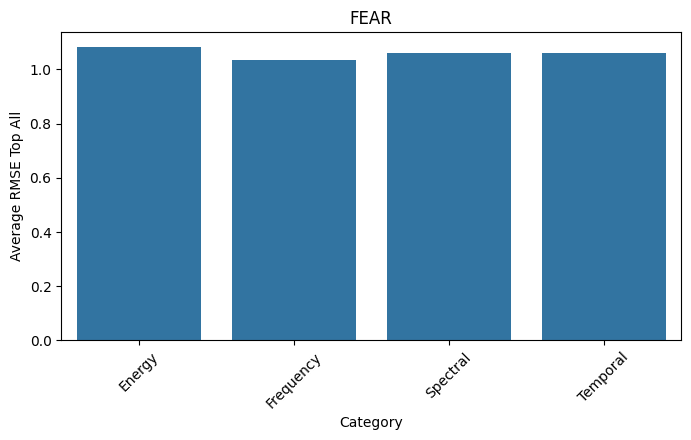

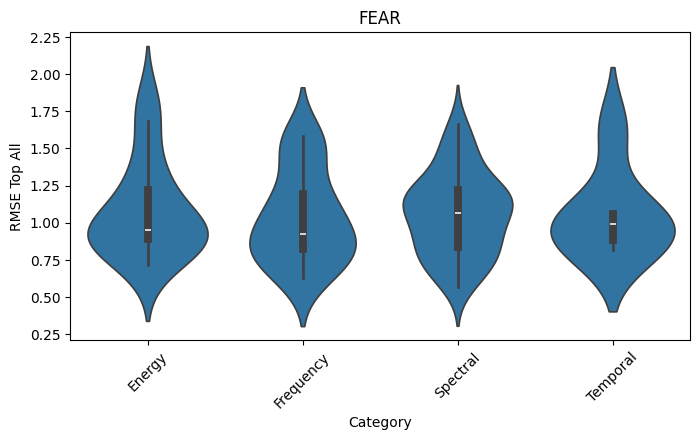

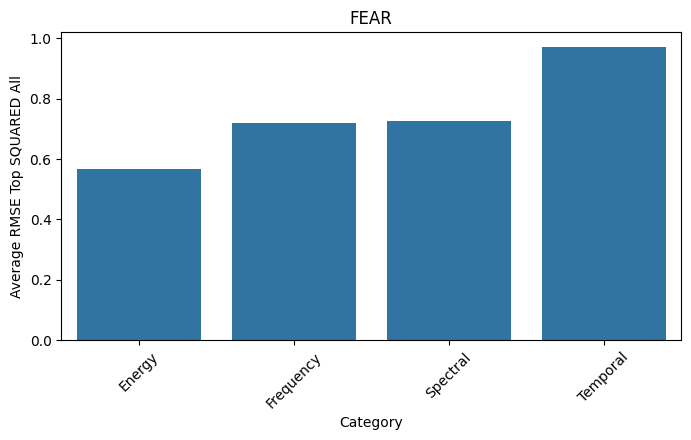

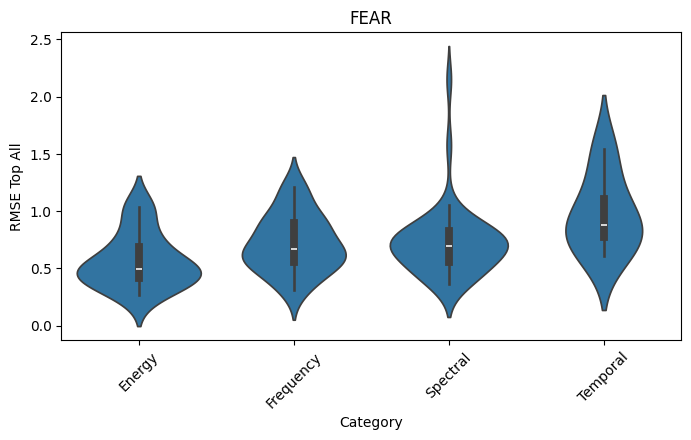

In [47]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('fear_ravdess_infogain.pkl')

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('FEAR')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Joy

In [48]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[3]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[3]] = sorted_df


  0%|          | 0/88 [00:00<?, ?it/s]/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.4509e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.70689e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.6062e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.79227e-08): result may not be accurate.
  dual_c

In [49]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
73,mfcc3V_sma3nz_stddevNorm,0.312,0.111,0.356,1.140,-0.920,2.995,0.219,2.204
9,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,0.397,0.172,0.434,1.095,-0.789,2.406,0.257,1.521
20,spectralFlux_sma3_amean,0.710,0.173,0.243,0.343,-0.988,2.097,0.557,0.408
65,slopeV500-1500_sma3nz_stddevNorm,0.515,0.253,0.492,0.956,-0.670,1.986,0.315,0.943
18,loudness_sma3_meanFallingSlope,0.916,0.257,0.281,0.306,-0.286,1.671,0.692,0.091
16,loudness_sma3_meanRisingSlope,1.040,0.261,0.251,0.241,0.163,1.549,0.809,-0.038
8,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,0.509,0.262,0.514,1.010,-0.644,1.955,0.304,0.965
80,spectralFluxUV_sma3nz_amean,0.842,0.270,0.321,0.381,-0.450,1.720,0.611,0.187
63,slopeV0-500_sma3nz_stddevNorm,0.702,0.294,0.418,0.596,-0.588,1.785,0.462,0.425
19,loudness_sma3_stddevFallingSlope,0.940,0.332,0.353,0.375,-0.164,1.546,0.661,0.063


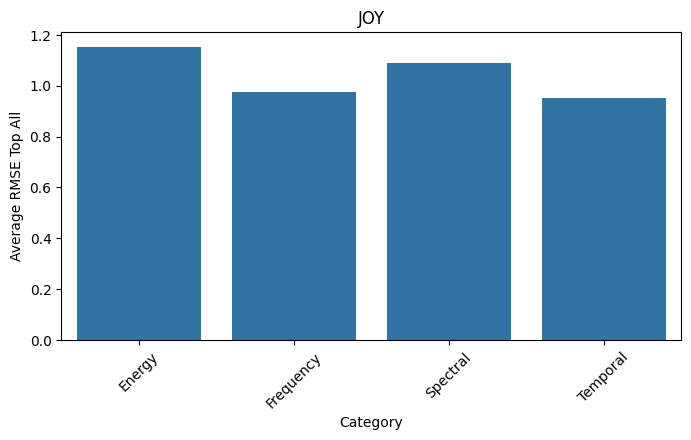

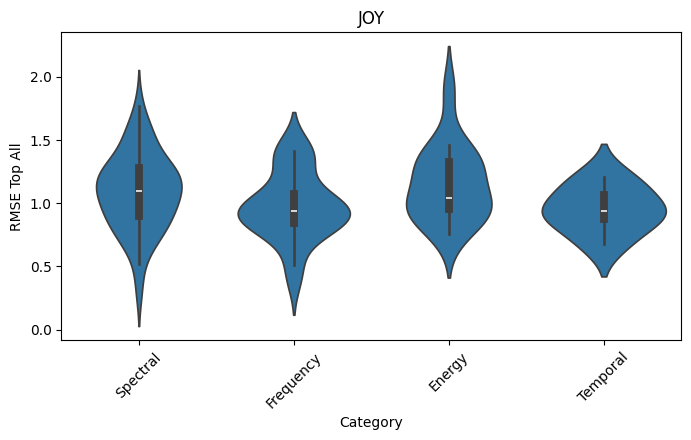

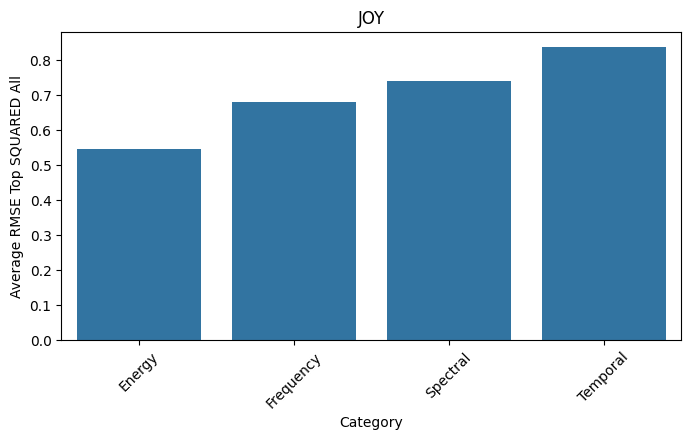

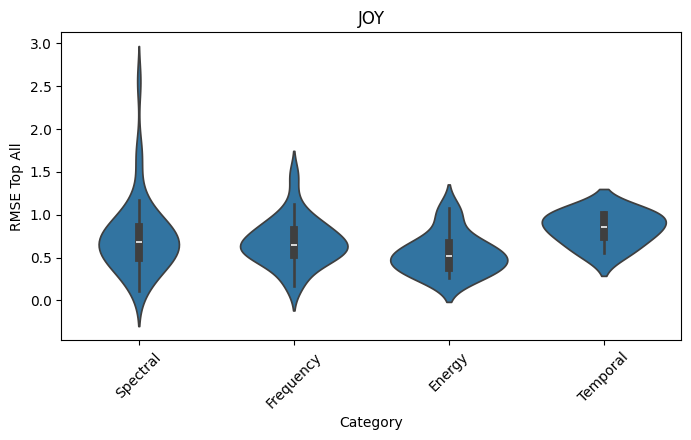

In [50]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('joy_ravdess_infogain.pkl')


# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('JOY')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Sadness

In [51]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[4]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[4]] = sorted_df


  0%|          | 0/88 [00:00<?, ?it/s]/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.54324e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.92163e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.55792e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=2.00348e-08): result may not be accurate.
  dual

In [52]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
15,loudness_sma3_pctlrange0-2,0.722,0.134,0.185,0.256,-1.260,2.205,0.600,0.385
66,spectralFluxV_sma3nz_amean,1.218,0.177,0.146,0.120,1.642,1.467,1.053,-0.179
59,alphaRatioV_sma3nz_stddevNorm,0.709,0.196,0.276,0.389,-0.876,2.031,0.538,0.411
19,loudness_sma3_stddevFallingSlope,0.914,0.201,0.220,0.241,-0.373,1.763,0.733,0.094
80,spectralFluxUV_sma3nz_amean,1.046,0.213,0.203,0.195,0.232,1.600,0.854,-0.044
17,loudness_sma3_stddevRisingSlope,0.910,0.213,0.234,0.257,-0.367,1.748,0.720,0.099
16,loudness_sma3_meanRisingSlope,1.126,0.227,0.202,0.179,0.662,1.506,0.920,-0.112
63,slopeV0-500_sma3nz_stddevNorm,0.589,0.247,0.419,0.711,-0.727,1.984,0.387,0.698
14,loudness_sma3_percentile80.0,1.235,0.272,0.220,0.178,1.180,1.374,0.991,-0.190
10,loudness_sma3_amean,1.512,0.296,0.195,0.129,3.152,1.171,1.243,-0.339


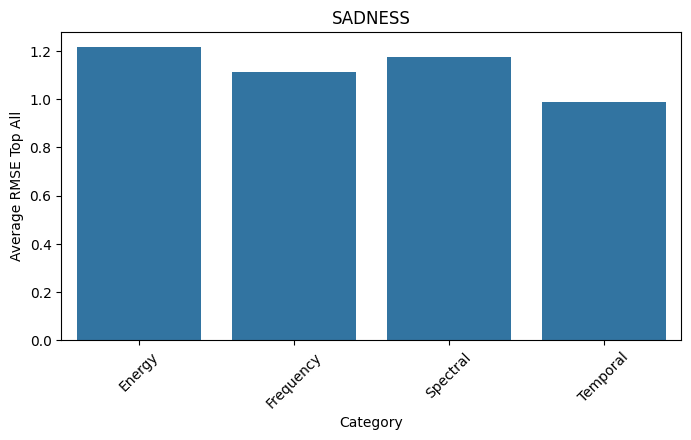

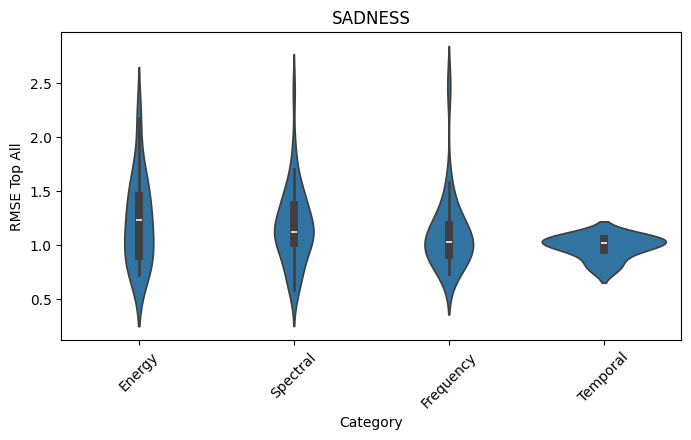

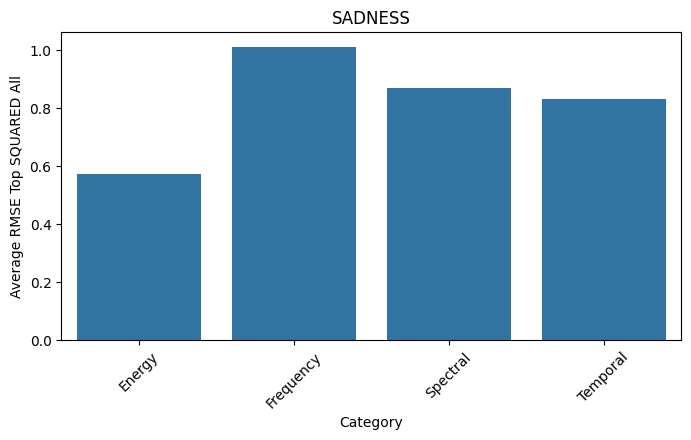

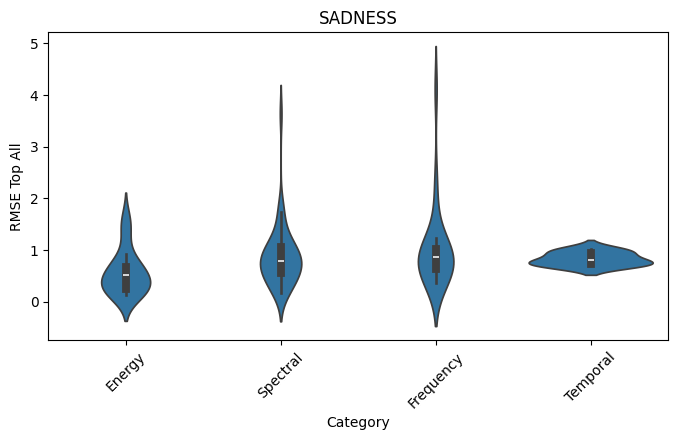

In [53]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('sadness_ravdess_infogain.pkl')

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('SADNESS')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


## Disgust

In [54]:
df = pd.DataFrame(top_wavlm_predict_ege(emotions[5]))
sorted_df = df.sort_values(by='rmse_top_squared_all', ascending=True)
predicted_df_dict[emotions[5]] = sorted_df


  0%|          | 0/88 [00:00<?, ?it/s]/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.50226e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.28444e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.80161e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/fabiocat/miniconda3/envs/ser/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.88381e-08): result may not be accurate.
  dual

In [55]:
sorted_df.head(10)

,Feature,rmse_top_all,rmse_top_squared_all,rmse_top,rmse_all,weighted_difference_rmse_all,harmonic_mean_metric_all,change_index_adjusted_performance_all,performance_weighted_change_score_all
59,alphaRatioV_sma3nz_stddevNorm,0.368,0.114,0.311,0.844,-1.094,2.947,0.270,1.718
6,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,0.354,0.189,0.535,1.511,-0.631,2.250,0.207,1.825
20,spectralFlux_sma3_amean,1.168,0.203,0.174,0.149,1.040,1.491,0.982,-0.144
14,loudness_sma3_percentile80.0,1.383,0.318,0.230,0.166,1.933,1.240,1.099,-0.277
39,logRelF0-H1-A3_sma3nz_stddevNorm,0.789,0.334,0.423,0.537,-0.440,1.650,0.517,0.268
25,mfcc2_sma3_stddevNorm,0.436,0.345,0.791,1.814,-0.433,1.629,0.198,1.292
69,mfcc1V_sma3nz_stddevNorm,0.894,0.347,0.388,0.434,-0.257,1.559,0.607,0.118
29,mfcc4_sma3_stddevNorm,0.603,0.361,0.599,0.994,-0.499,1.664,0.331,0.659
19,loudness_sma3_stddevFallingSlope,1.326,0.400,0.302,0.228,1.233,1.228,0.981,-0.246
66,spectralFluxV_sma3nz_amean,1.874,0.406,0.217,0.116,5.260,0.956,1.509,-0.466


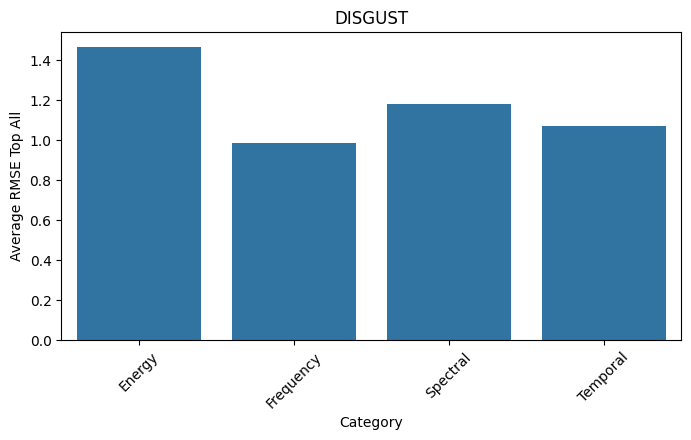

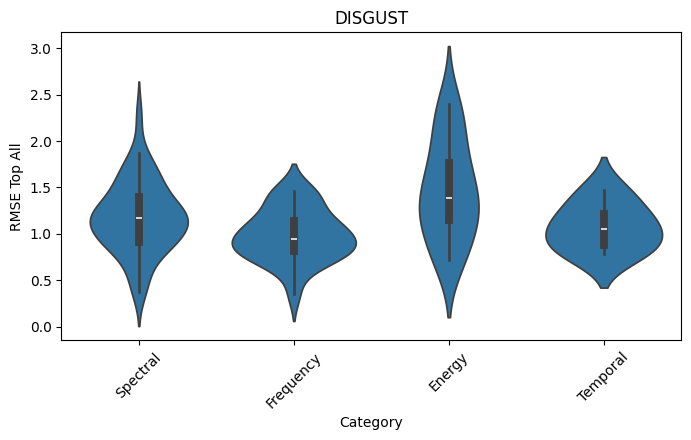

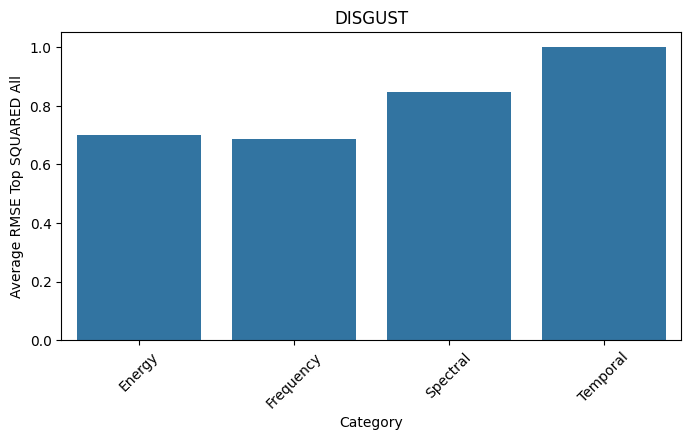

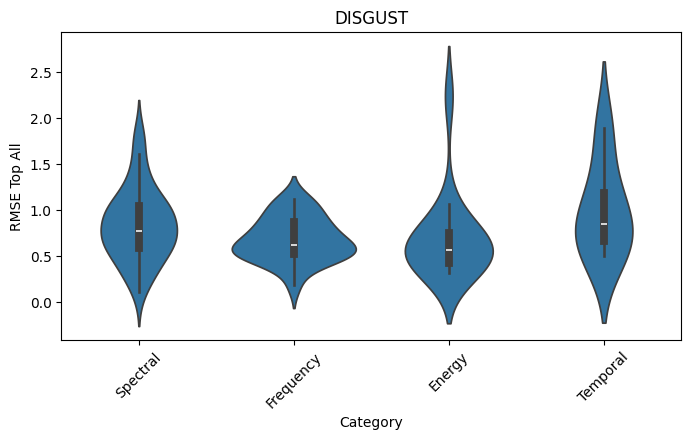

In [56]:
# Add 'category' column
sorted_df['category'] = sorted_df['Feature'].map(egemaps_category_dict)

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_all'].mean().reset_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_all', data=category_avg)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_all', data=sorted_df)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()

# Compute average rmse_top_all for each category
category_avg = sorted_df.groupby('category')['rmse_top_squared_all'].mean().reset_index()
sorted_df.to_pickle('disgust_ravdess_infogain.pkl')


# Plot bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='rmse_top_squared_all', data=category_avg)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('Average RMSE Top SQUARED All')
plt.xticks(rotation=45)
plt.show()

# Plot violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(x='category', y='rmse_top_squared_all', data=sorted_df)
plt.title('DISGUST')
plt.xlabel('Category')
plt.ylabel('RMSE Top All')
plt.xticks(rotation=45)
plt.show()


# SER Performance Summary

In [57]:
df = pd.DataFrame(Performance)
df

,eGeMAPS,WavLM_all,WavLM_top_features
anger,92.1,98.1,100.0
fear,91.8,96.6,99.0
neutrality,0.0,0.0,0.0
joy,83.8,93.3,99.5
sadness,75.6,82.7,96.5
disgust,86.3,99.1,100.0
